# Statical Learning. Final Project. Phase 2
### Golnoosh Abdollahinejad

In [1]:
#lib
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from scipy import signal
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RForest
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

### A) Read Data

In [2]:
# read data sets from paths
train_path = 's2_train.npy'
test_path = 's2_test.npy'
# training data
data_train = np.load(train_path, allow_pickle=True)

# test data
data_test = np.load(test_path, allow_pickle=True)


### B) Preprocessing

Automatic Multiscale-based Peak Detection (AMPD) is a peak detector, which will be used in preprocessing of PPG samples

ampdLib implements automatic multiscale-based peak detection (AMPD) algorithm as in An Efficient Algorithm for Automatic Peak Detection in Noisy Periodic and Quasi-Periodic Signals, by Felix Scholkmann, Jens Boss and Martin Wolf, Algorithms 2012, 5, 588-603.

https://github.com/LucaCerina/ampdLib

In [3]:
global plot_flag
plot_flag = 1

In [4]:
# AMPD function
def ampd(sigInput, LSMlimit = 1):
    """Find the peaks in the signal with the AMPD algorithm.
    
        Original implementation by Felix Scholkmann et al. in
        "An Efficient Algorithm for Automatic Peak Detection in 
        Noisy Periodic and Quasi-Periodic Signals", Algorithms 2012,
            5, 588-603

        Parameters
        ----------
        sigInput: ndarray
            The 1D signal given as input to the algorithm
        lsmLimit: float
            Wavelet transform limit as a ratio of full signal length.
            Valid values: 0-1, the LSM array will no longer be calculated after this point
                which results in the inability to find peaks at a scale larger than this factor.
                For example a value of .5 will be unable to find peaks that are of period 
                1/2 * signal length, a default value of 1 will search all LSM sizes.

        Returns
        -------
        pks: ndarray
            The ordered array of peaks found in sigInput
    """
        
    # Create preprocessing linear fit	
    sigTime = np.arange(0, len(sigInput))
    
    # Detrend
    dtrSignal = (sigInput - np.polyval(np.polyfit(sigTime, sigInput, 1), sigTime)).astype(float)
    
    N = len(dtrSignal)
    L = int(np.ceil(N*LSMlimit / 2.0)) - 1
    
    # Generate random matrix
    LSM = np.ones([L,N], dtype='uint8')
    
    # Local minima extraction
    for k in range(1, L):
        LSM[k - 1, np.where((dtrSignal[k:N - k - 1] > dtrSignal[0: N - 2 * k - 1]) & (dtrSignal[k:N - k - 1] > dtrSignal[2 * k: N - 1]))[0]+k] = 0
    
    pks = np.where(np.sum(LSM[0:np.argmin(np.sum(LSM, 1)), :], 0)==0)[0]
    return pks

Preprocessing part 1: 

1. This function find peaks using ***ampd*** on each long PPG signal

2. delete peaks with nonvalid-value, too small or too large, using sliding window (averaging) (they can be plotted)

3. separate 10-peaks PPG samples and synchronously BP samples

also check if length of samples reach 1500 point, then use *ampd* again to perform better local peak detection; becuase ampd is a local peak detector and for compressed peaks performs better on smaller area.


Return samples as list of arrays, becuase their lengths are not equal.

In [5]:
#AMPD devider with threshold and length-checking
def preprocess1(N, data, test_data=False):
    """
    N:      number of signals
    data:   list of (N) PPG and BP long signals
    """
    nonvalid_peak_count = 0
    #---constant value----------------------------------------------------------
    sws = 5 #sliding_window_size
    swul = 1.4 #sliding window upper limit
    swll = 0.7 #sliding window lower limit
    #---low pass FILTER---------------------------------------------------------
    #parameter a & b for low pass cheby filter(type 1)
    b, a = signal.cheby1(5, 1.01, [10], btype='low', fs=125)
    #---------------------------------------------------------------------------
    #list of arrays for PPG and BP signals after deviding to 10-peaks samples
    #(nonequal-length)
    list_array_PPG = []
    list_array_BP  = []
    #---------------------------------------------------------------------------
    for i in range(N):
        long_signal_PPG = data[i][0][:] #PPG long signal
        if not test_data:
            long_signal_BP  = data[i][1][:] #BP long signal
        #filter PPG signal
        long_signal_PPG = signal.filtfilt(b, a, long_signal_PPG)
        #-----------------------------------------------------------------------
        #ampd function find peaks and returns p as peak's indexes
        p = ampd(long_signal_PPG, LSMlimit = 0.1)
        pre = p.shape
        #===nonvalid-value peaks================================================
        #list for nonvalid-value peaks
        nonvalid_peak = []       
        #sliding window on each 10 detected-peaks to delete nonvalid ones due...
        #... to average of local peaks, lower(0.7) and upper(1.4) limitation
        #i_plot = 1
        for k in range(sws, p.shape[0] - sws):
            #check nonvalid peaks by averaging on sliding window
            peak_avg = np.mean(long_signal_PPG[p[k-sws: k+sws]])
            
            if (long_signal_PPG[p[k]] < swll * peak_avg) or (long_signal_PPG[p[k]] > swul * peak_avg):
                nonvalid_peak.append(k)
                nonvalid_peak_count += 1
                #---just plot bad peaks :)--------------------------------------
                if plot_flag: #plot detected non-valid peaks
                    plt.figure(figsize=(10,5), dpi=50)
                    plt.plot(range(p[k-sws],p[k+sws]), long_signal_PPG[p[k-sws]:p[k+sws]], 'g')
                    plt.plot(p[k], long_signal_PPG[p[k]], 'ro')
                    plt.title('nonvalid peak from signal ' + str(i) + ' out of 50')
                    plt.show()
                #---------------------------------------------------------------
        #delete nonvalid peaks
        p = np.delete(p, nonvalid_peak, axis=None)
        #===make 10-peaks samples===============================================
        j = 0
        #while j < p.shape[0] - 10:
        for j in range(0, p.shape[0] - 10, 10):
            #separate 10-peaks sapmles
            current_part_PPG = long_signal_PPG[p[j]:p[j+10]]
            if not test_data:
                current_part_BP = long_signal_BP[p[j]:p[j+10]]
            #Check lenght of sample
            #if it was more than 1500 then AMPD didn't find LOCAL peaks well
            #use AMPD on separated part again
            length = (current_part_PPG).shape[0]
            if length > 1500 : #peaks are missed, so length of this frame exceed max-limit
                pp = ampd(current_part_PPG, LSMlimit = 0.1) #new peaks
                #append 10-peaks PPG and BP samples due to new peaks
                for k in range(0, pp.shape[0] - 10, 10):
                    list_array_PPG.append(current_part_PPG[pp[k]: pp[k+10]])
                    if not test_data:
                        list_array_BP.append(current_part_BP[pp[k]: pp[k+10]])
            else: #normal lenght
                #make list of arrays for 10-peak PPG samples
                list_array_PPG.append(long_signal_PPG[p[j]:p[j+10]])
                #also for BP synchronously
                if not test_data:
                    list_array_BP.append(long_signal_BP[p[j]:p[j+10]])
        #=======================================================================
    N = len(list_array_PPG)
    print(nonvalid_peak_count, 'nonvalid-value peaks detected')
    print('number of 10-peaks samples', N)
    if not test_data:
        print('Do BP and PPG have the same number of samples?', N == len(list_array_BP))
        return N, list_array_PPG, list_array_BP
    else:
        return N, list_array_PPG

Preprocessing part 2: as period of each peak is between 50 to 125 points, if any sample reach these 2 limitation, it shows that sample has some destortion or noise, so it will be deleted from dataset.

(125 = fs * max_period = 125 Hz * 1 sec)

In [6]:
#simple: threshold onre length of samples
def preprocess2(N, data, test_data=False):
    # list of arrays
    list_array_PPG = data[0]
    if not test_data:
        list_array_BP = data[1]
    
    count = 0
    nonvalid_sample = []
    for i in range(len(list_array_PPG)): # for all PPG samples
        if list_array_PPG[i].shape[0] > 1230 or list_array_PPG[i].shape[0] < 500:
            #length os samples reach limit
            nonvalid_sample.append(i)
            if plot_flag:
                print('length of sample', list_array_PPG[i].shape[0])
                plt.figure(figsize=(10,5), dpi=50)
                plt.plot(list_array_PPG[i])
                plt.show()
                #plt.figure(figsize=(10,5), dpi=50)
                #plt.plot(list_array_BP2[i])
                #plt.show()
            count += 1

    #delete nonvalid samples
    list_array_PPG_new = np.delete(list_array_PPG, nonvalid_sample, axis=0)
    if not test_data:
        list_array_BP_new = np.delete(list_array_BP, nonvalid_sample, axis=0)
    print(count, 'samples are deleted from dataset')
    #new number of samples
    N = len(list_array_PPG_new)
    print(N, 'samples left')
    #return updated list of arrays
    if not test_data:
        print('Do BP and PPG have the same number of samples?', N == len(list_array_BP_new))
        return N, list_array_PPG_new, list_array_BP_new
    else:
        return N, list_array_PPG_new

Preprocessing part 3: This part check distant between 2 following peaks and compare it with max/min period of PPG peaks. If it reaches limitations means sample must be deleted from dataset.

In [7]:
#delete some samples #2
def preprocess3(N, data, test_data=False):
    # list of arrays
    list_array_PPG = data[0]
    if not test_data:
        list_array_BP = data[1]
    #---------------------------------------------------------------------------
    count = 0
    nonvalid_sample = []
    for i in range(len(list_array_PPG)):
        signal = list_array_PPG[i]
        peak = ampd(signal, LSMlimit = 0.1)

        ## we are sure that first and last point of each sample was detected ...
        ##... as peak but they won't detected here becuase of local algorithem

        # add the first point as the first peak.
        peak = np.insert(peak, 0, 0) 
        # add the last point as the last peak
        peak = np.insert(peak, len(peak), len(signal)-1) 
        #-----------------------------------------------------------------------
        #calculate distant between 2 following peaks
        dist = []
        for j in range(1, len(peak)):
            dist.append(peak[j]-peak[j-1])
        dist = np.array(dist)
        #-----------------------------------------------------------------------
        # use max/min period of peaks to detect nonvalid peaks/samples
        problem_peak = np.where((dist > 125)+(dist < 40))[0]
        if np.any(dist > 125) or np.any(dist < 40):
            nonvalid_sample.append(i) #save index of noisy samples
            
            if plot_flag: 
                # plot deleted sample with its related peaks that their ...
                # ... distant is not valid
                print("peaks' distant", dist[(dist > 125) + (dist < 40)])
                plt.figure(figsize=(10,5), dpi=50)
                plt.plot(signal)
                plt.plot(peak[problem_peak], signal[peak[problem_peak]], 'ro')
                plt.plot(peak[problem_peak+1], signal[peak[problem_peak+1]], 'ro')
                plt.show()
                #plt.figure(figsize=(10,5), dpi=50)
                #plt.plot(list_array_BP[i])
                #plt.show()
            count += 1

    print(count, 'samples are deleted from dataset')
    list_array_PPG_new = np.delete(list_array_PPG, nonvalid_sample, axis=0)
    if not test_data:
        list_array_BP_new = np.delete(list_array_BP, nonvalid_sample, axis=0)
    #new number of samples
    N = len(list_array_PPG_new)
    print(N, 'samples left')
    #return updated list of arrays
    if not test_data:
        print('Do BP and PPG have the same number of samples?', N == len(list_array_BP_new))
        
        return N, list_array_PPG_new, list_array_BP_new
    else:
        return N, list_array_PPG_new

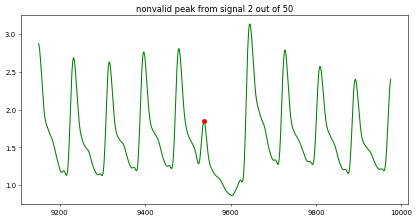

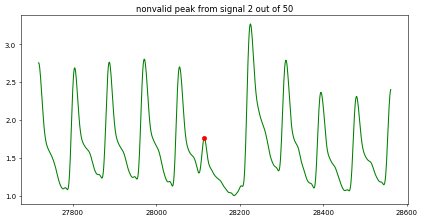

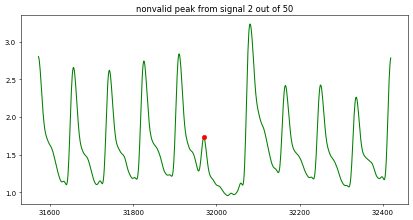

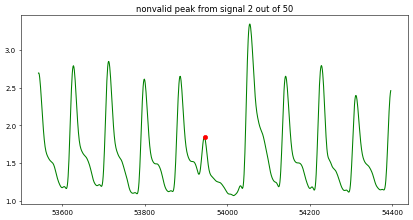

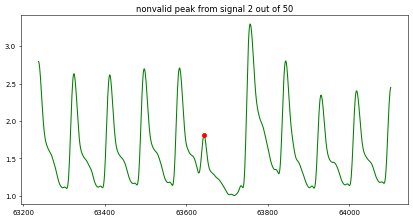

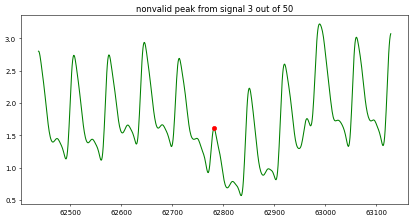

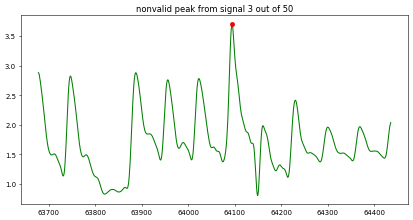

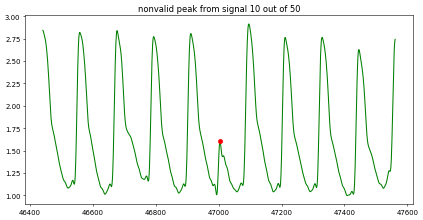

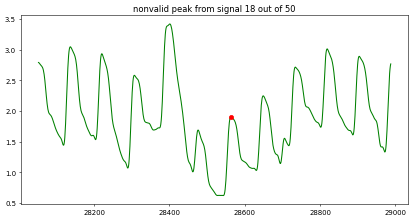

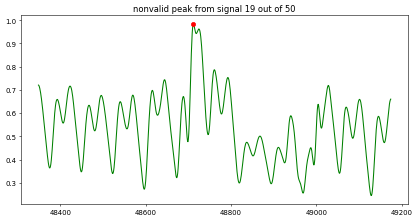

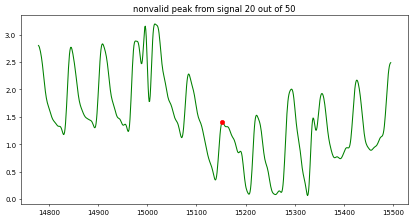

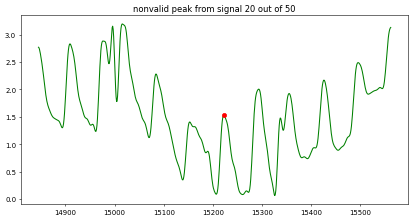

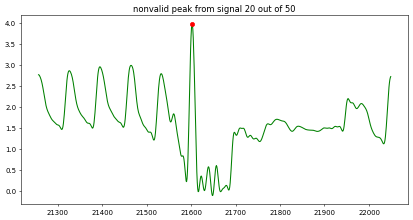

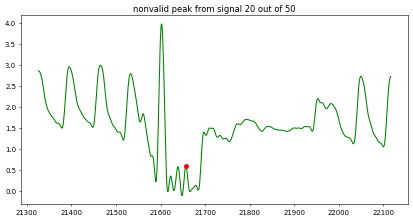

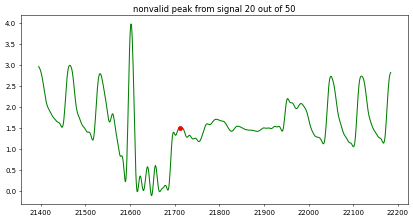

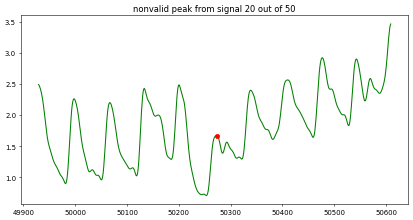

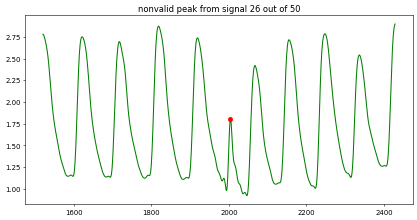

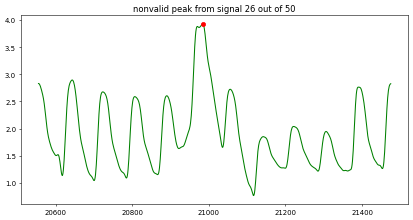

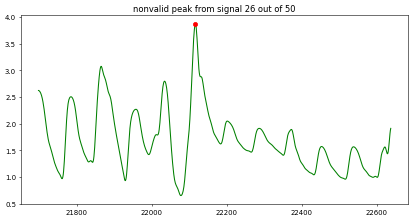

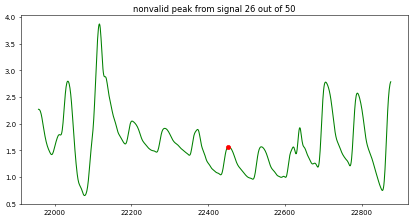

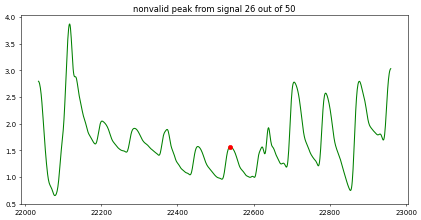

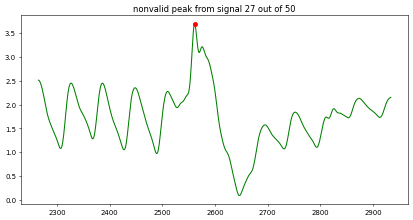

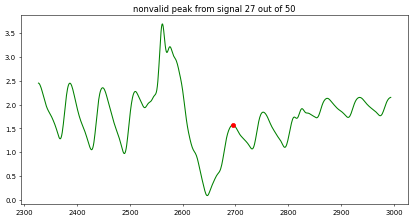

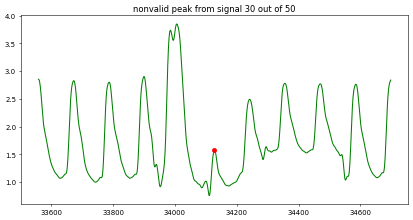

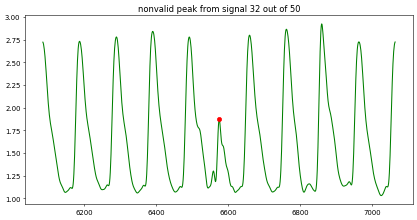

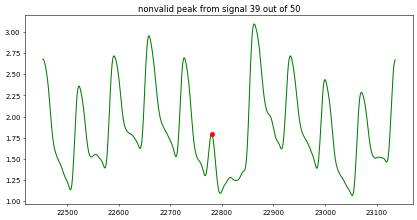

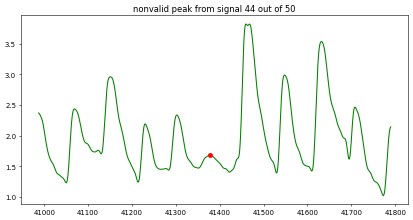

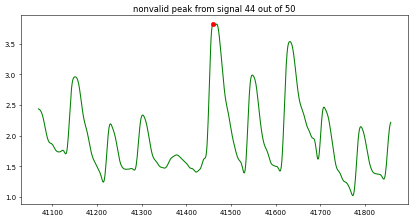

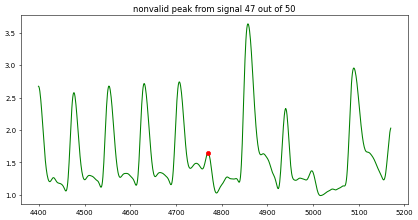

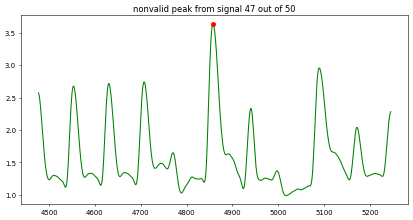

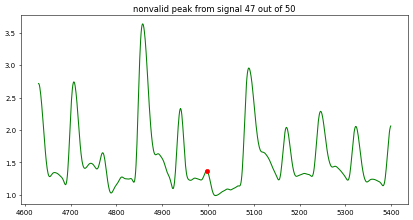

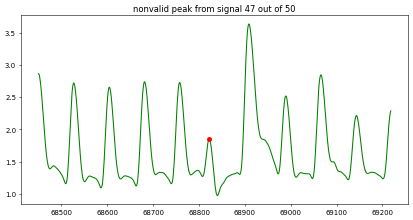

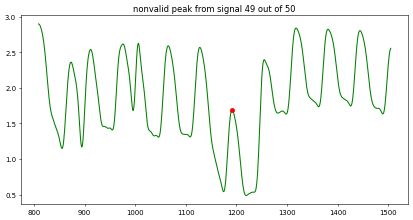

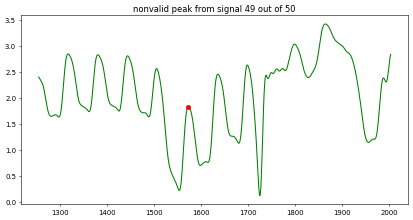

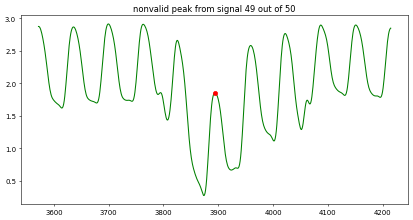

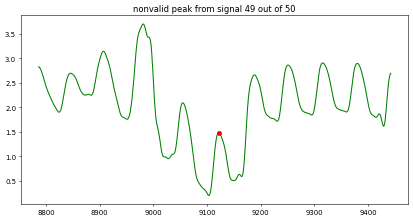

36 nonvalid-value peaks detected
number of 10-peaks samples 3765
Do BP and PPG have the same number of samples? True


In [8]:
plot_flag = 1
Ntrain, list_array_PPG, list_array_BP = preprocess1(50, data_train )

deleting nonvalid-value peaks helps part 2 & 3 of preprocessing to delete noisy samples due to long-length samples and long distant between 2 following peaks.

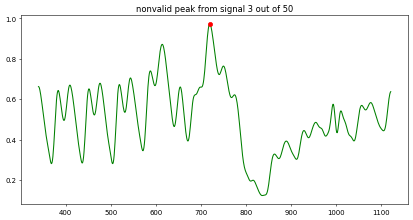

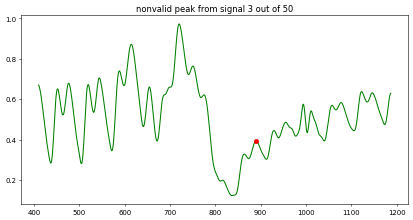

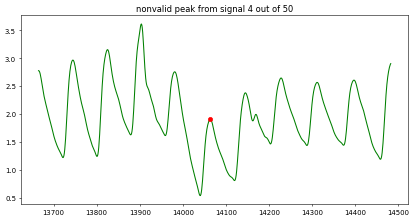

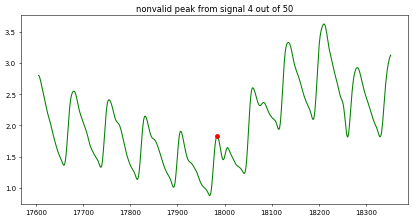

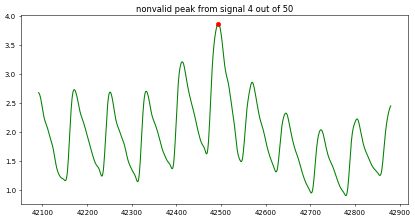

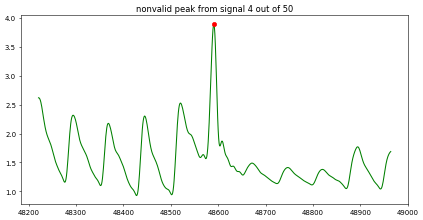

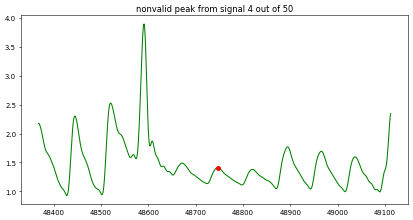

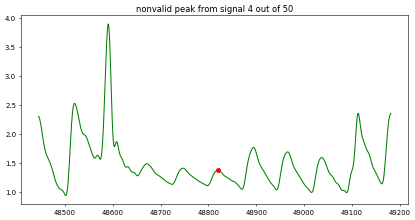

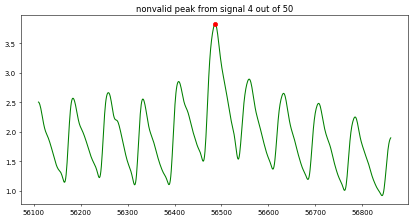

9 nonvalid-value peaks detected
number of 10-peaks samples 412


In [9]:
Ntest, list_array_PPG_test = preprocess1(5, data_test, test_data=True)

the following blocks plot long-length samples which are deleted from dataset

length of sample 1257


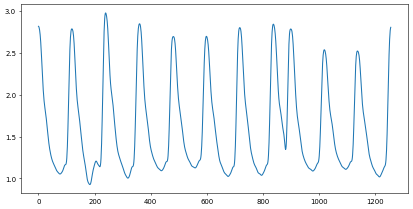

length of sample 1240


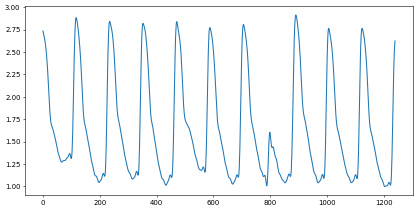

length of sample 1254


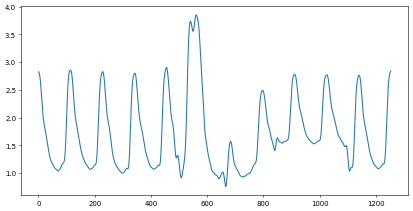

length of sample 1257


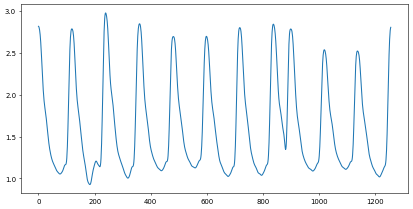

length of sample 1239


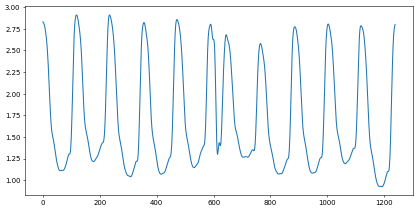

length of sample 1245


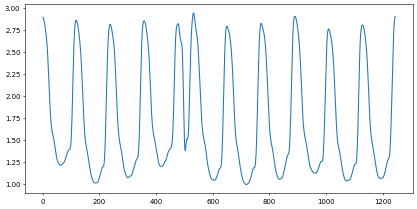

length of sample 1243


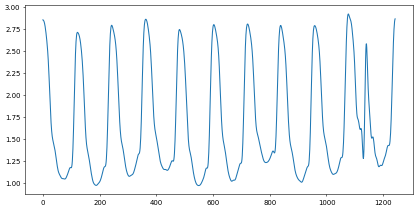

length of sample 1258


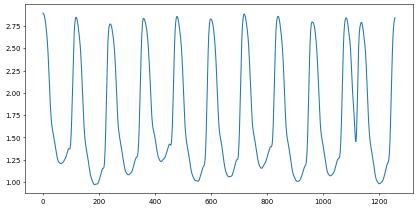

length of sample 1256


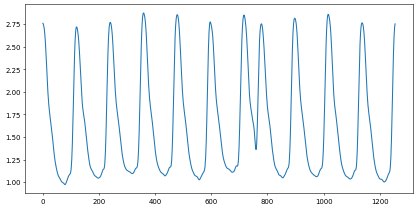

9 samples are deleted from dataset
3756 samples left
Do BP and PPG have the same number of samples? True


In [10]:
#train
plot_flag = 1
Ntrain, list_array_PPG, list_array_BP = preprocess2(Ntrain, [list_array_PPG, list_array_BP] )

In [11]:
#test
Ntest, list_array_PPG_test = preprocess2(Ntest, [list_array_PPG_test], test_data=True)

0 samples are deleted from dataset
412 samples left


the following blocks plot samples with nonvalid distant between 2 peaks, which are deleted from dataset

peaks' distant [128]


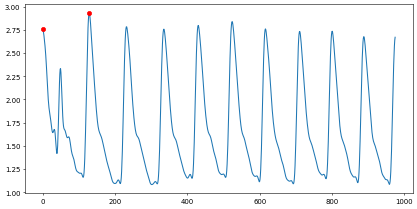

peaks' distant [126]


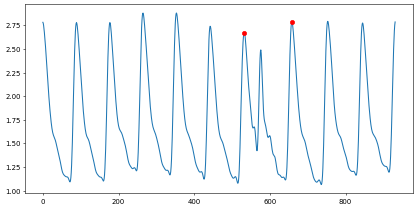

peaks' distant [126]


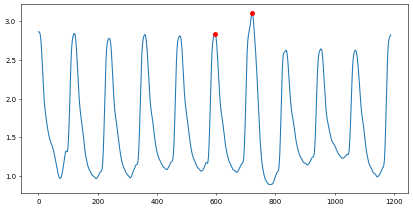

peaks' distant [147]


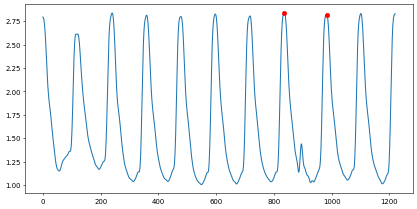

peaks' distant [150]


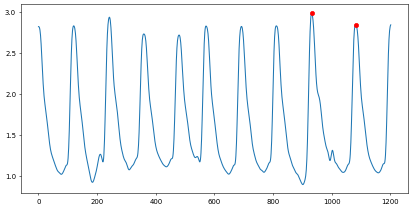

peaks' distant [140]


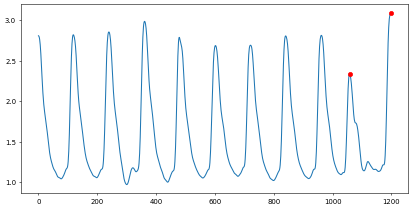

peaks' distant [148]


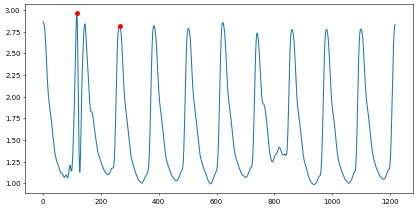

peaks' distant [156]


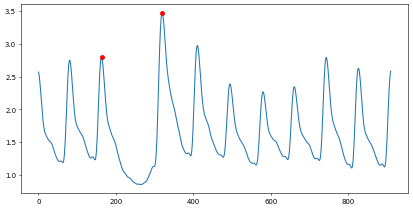

peaks' distant [170]


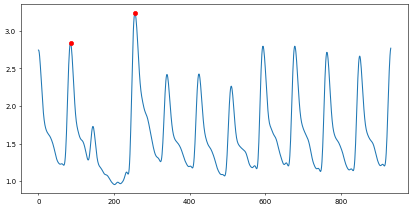

peaks' distant [140]


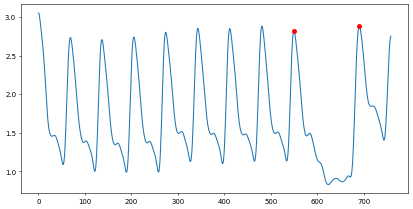

peaks' distant [39]


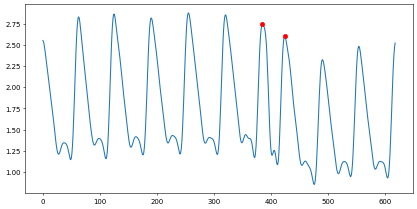

peaks' distant [39]


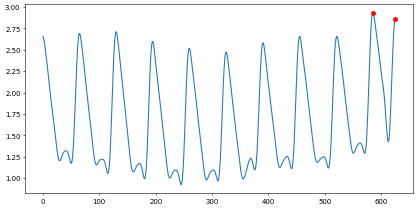

peaks' distant [36]


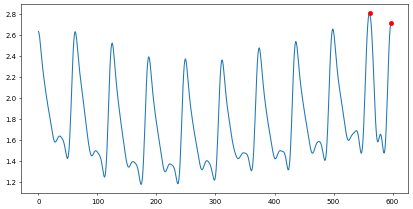

peaks' distant [39]


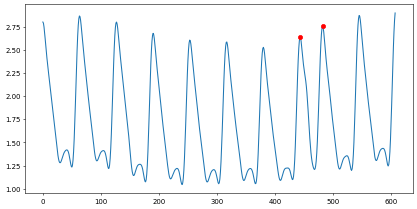

peaks' distant [38]


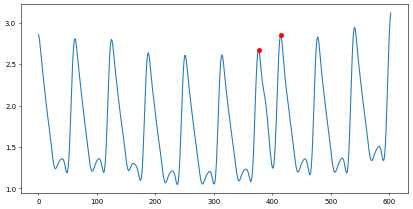

peaks' distant [37]


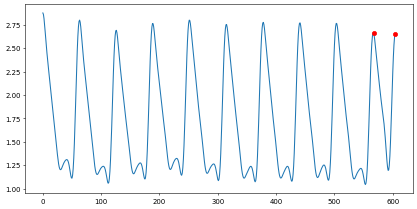

peaks' distant [38]


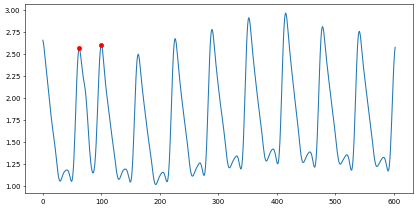

peaks' distant [132]


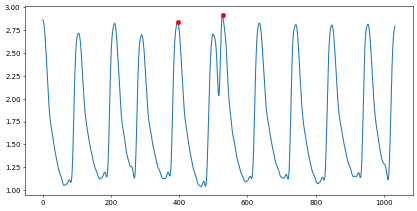

peaks' distant [132]


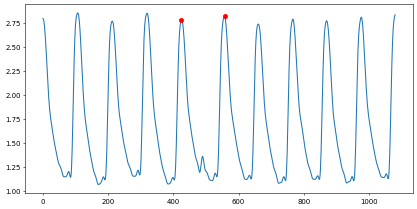

peaks' distant [134]


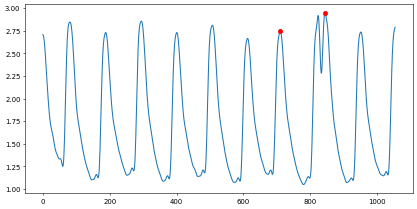

peaks' distant [129]


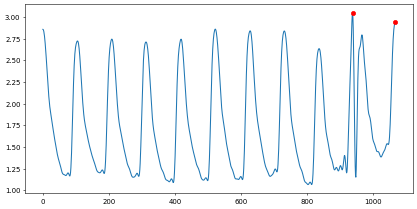

peaks' distant [169]


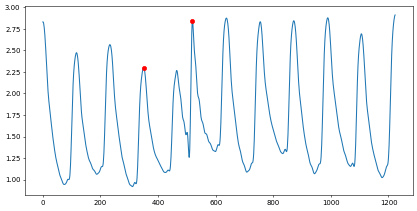

peaks' distant [128]


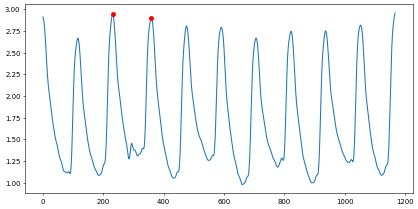

peaks' distant [134]


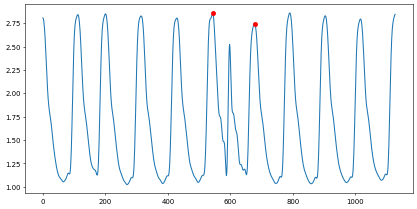

peaks' distant [145]


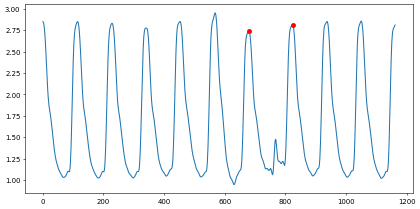

peaks' distant [138]


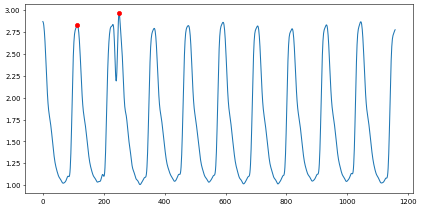

peaks' distant [134]


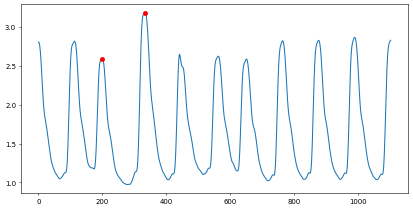

peaks' distant [140]


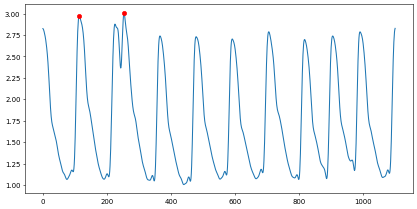

peaks' distant [131]


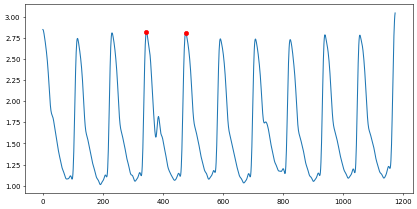

peaks' distant [148]


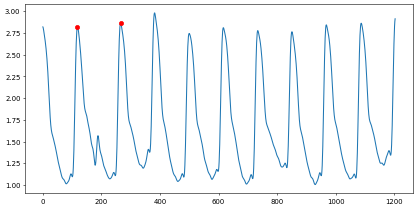

peaks' distant [155]


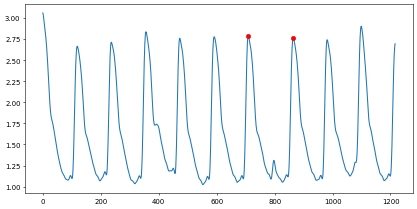

peaks' distant [161]


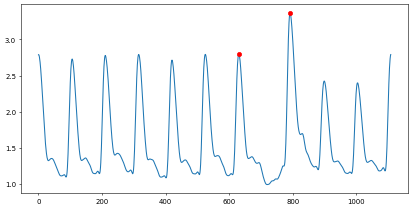

peaks' distant [130]


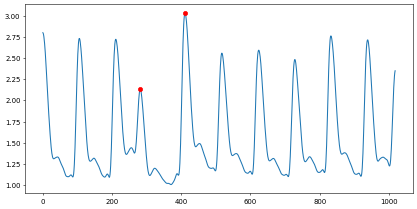

peaks' distant [128]


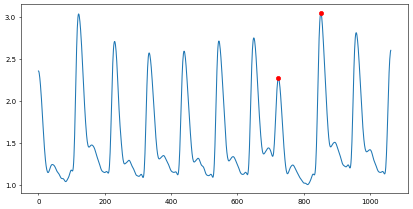

peaks' distant [127]


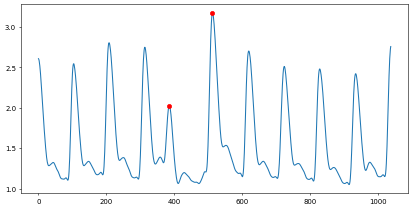

peaks' distant [196]


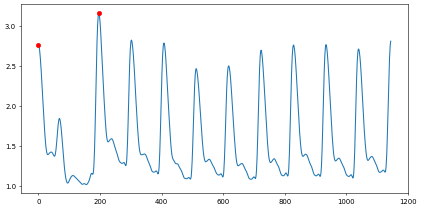

peaks' distant [136]


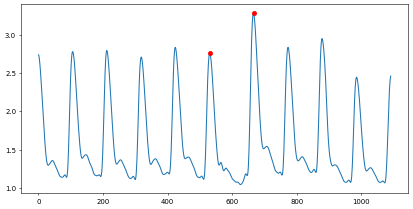

peaks' distant [130]


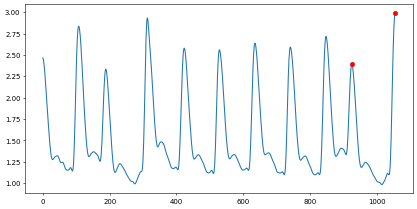

peaks' distant [129]


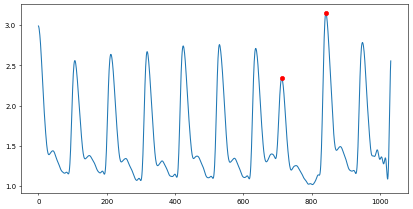

peaks' distant [127]


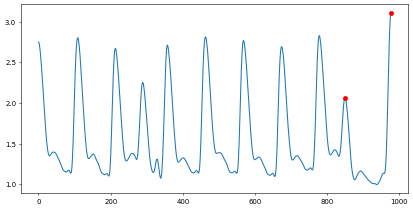

peaks' distant [152]


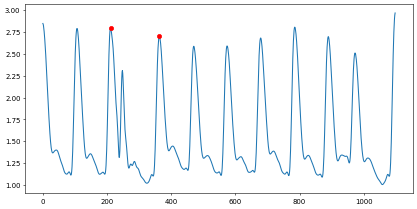

peaks' distant [130]


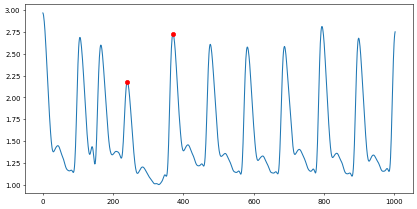

peaks' distant [152]


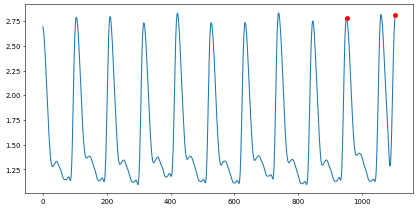

peaks' distant [195]


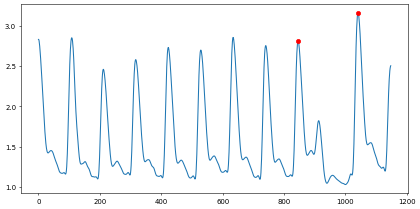

peaks' distant [130]


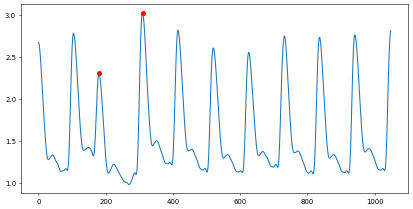

peaks' distant [138]


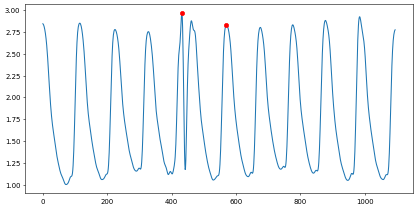

peaks' distant [141]


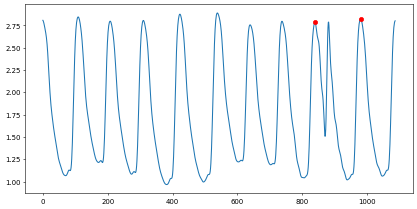

peaks' distant [138]


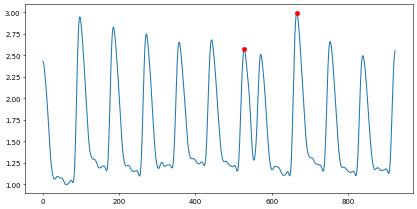

peaks' distant [141]


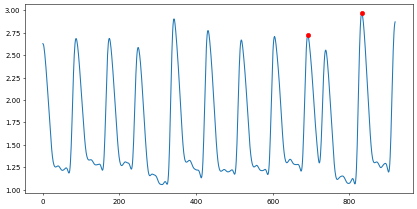

peaks' distant [128]


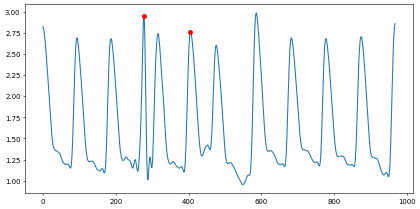

peaks' distant [138]


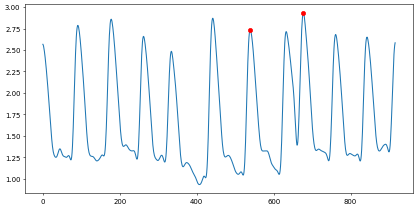

peaks' distant [126]


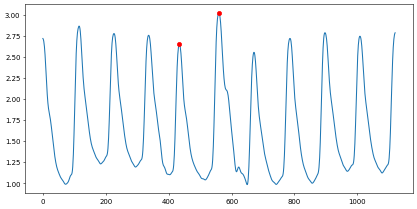

peaks' distant [131]


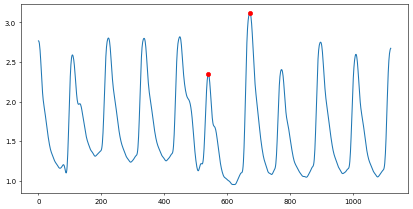

peaks' distant [130]


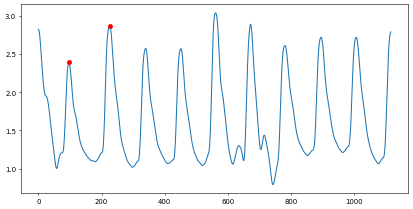

peaks' distant [126 127]


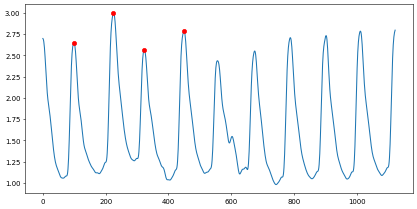

peaks' distant [129]


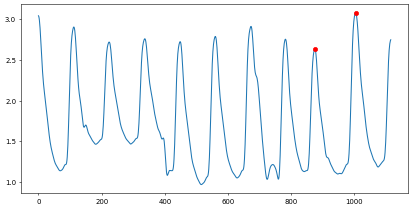

peaks' distant [38]


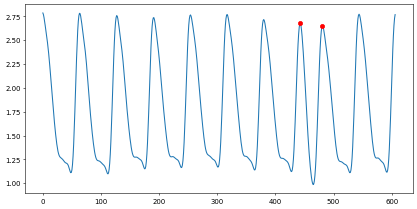

peaks' distant [37]


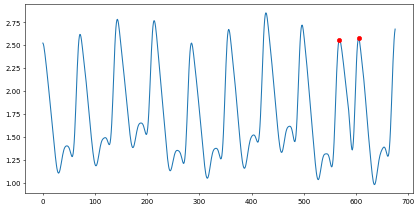

peaks' distant [129]


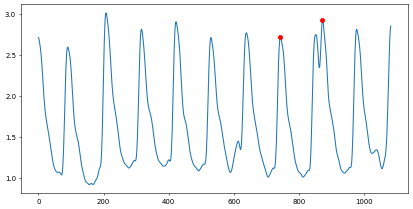

peaks' distant [126]


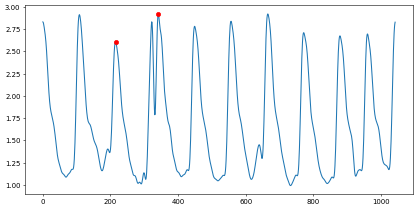

peaks' distant [153]


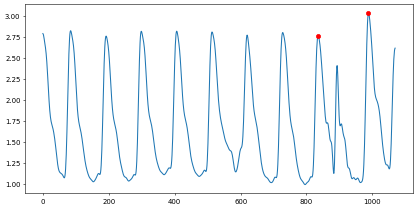

peaks' distant [134]


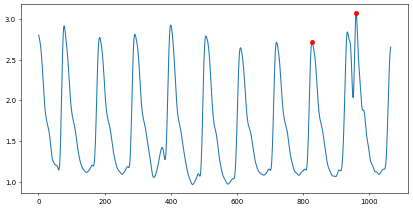

peaks' distant [149]


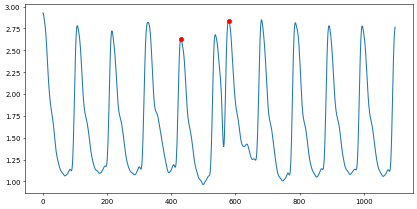

peaks' distant [163]


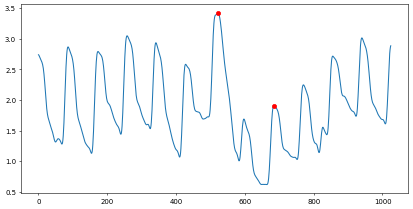

peaks' distant [173]


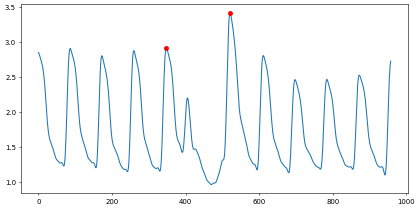

peaks' distant [173]


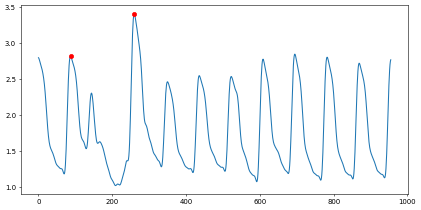

peaks' distant [191]


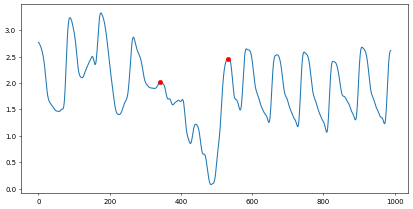

peaks' distant [156]


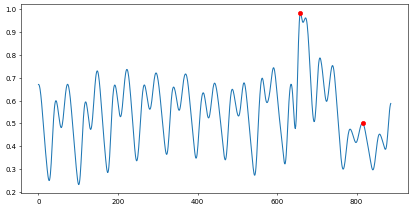

peaks' distant [147]


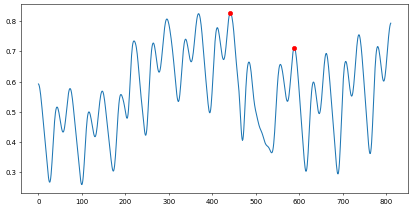

peaks' distant [146]


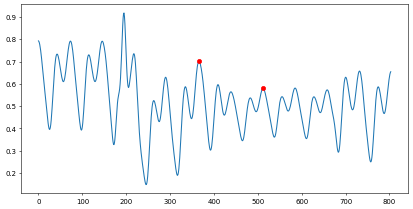

peaks' distant [160]


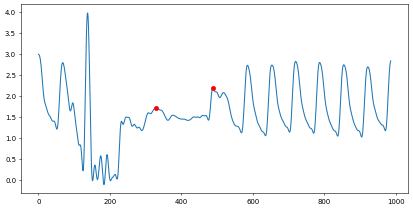

peaks' distant [139]


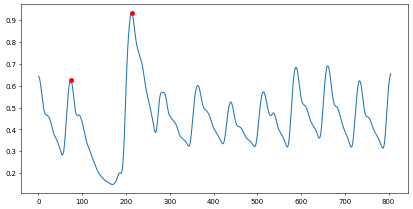

peaks' distant [138]


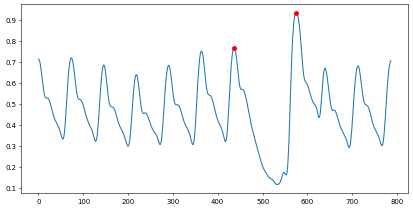

peaks' distant [141]


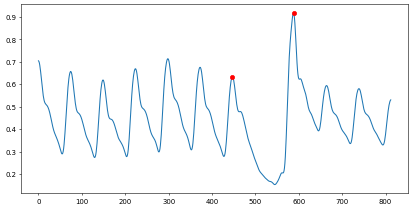

peaks' distant [138]


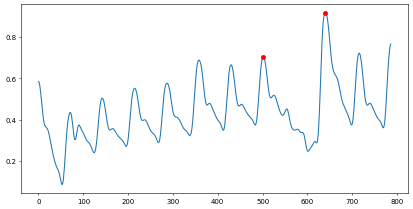

peaks' distant [139]


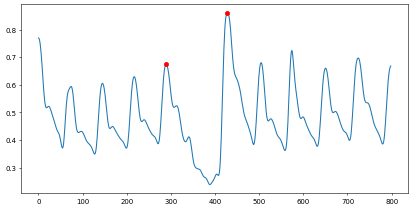

peaks' distant [138 140]


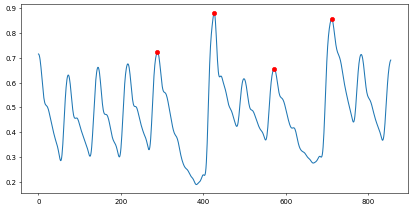

peaks' distant [137]


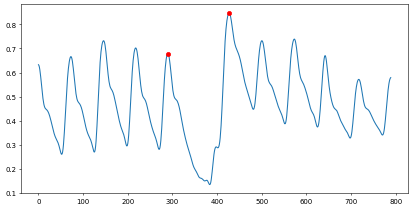

peaks' distant [138]


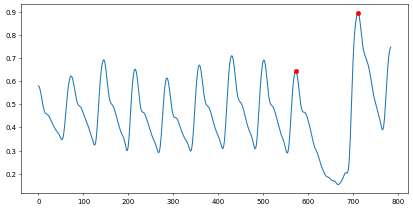

peaks' distant [137]


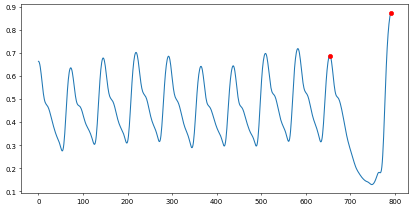

peaks' distant [138]


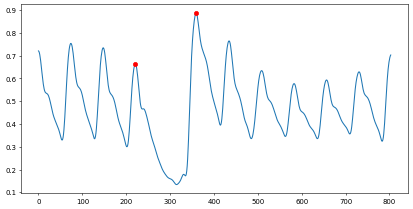

peaks' distant [144]


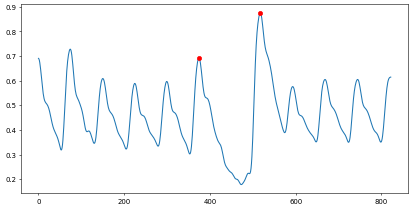

peaks' distant [140]


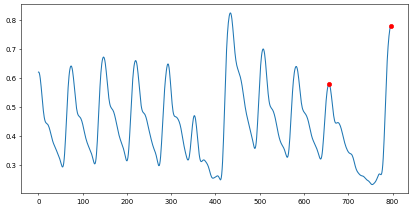

peaks' distant [140]


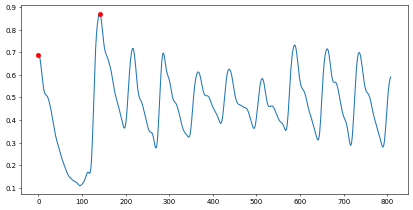

peaks' distant [139]


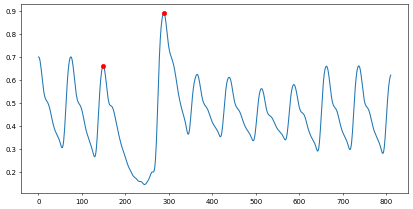

peaks' distant [138]


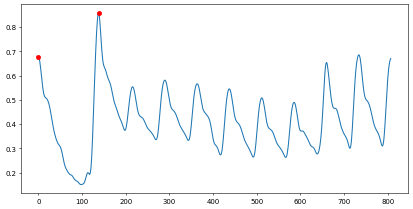

peaks' distant [141]


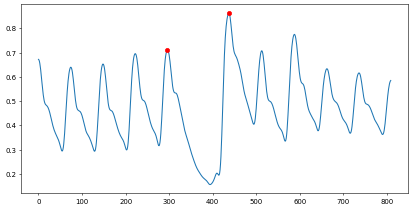

peaks' distant [138]


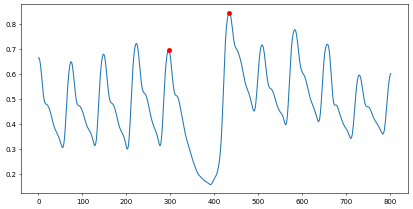

peaks' distant [141]


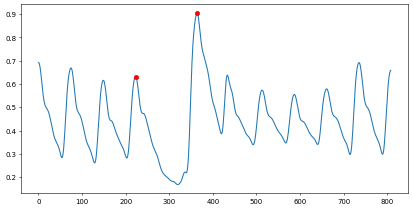

peaks' distant [140 139]


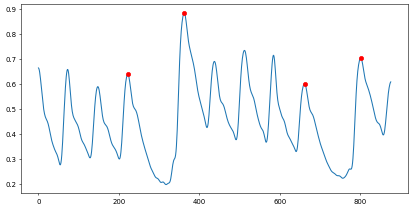

peaks' distant [145]


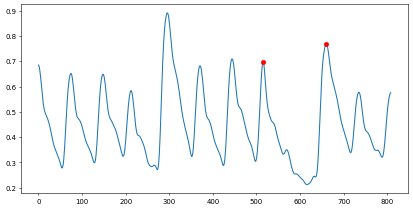

peaks' distant [141]


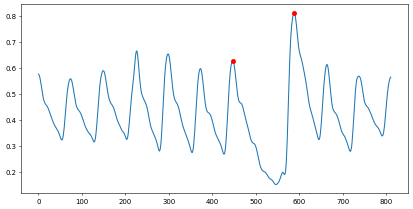

peaks' distant [144]


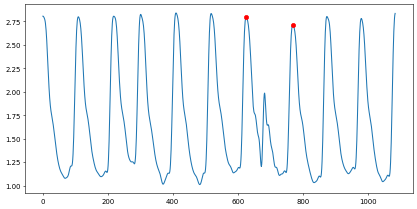

peaks' distant [128]


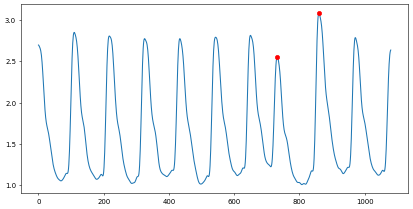

peaks' distant [144]


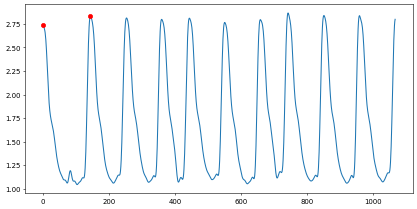

peaks' distant [135]


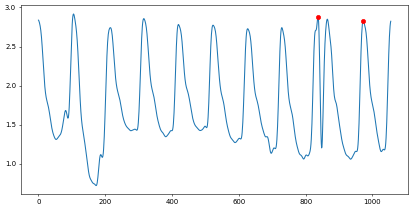

peaks' distant [134]


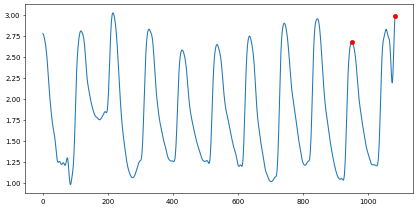

peaks' distant [133]


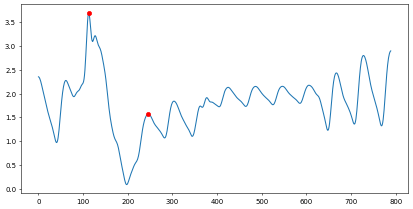

peaks' distant [153]


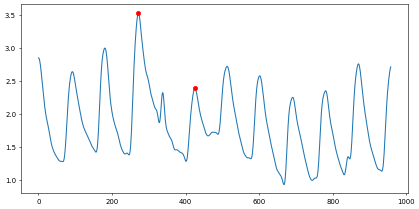

peaks' distant [127]


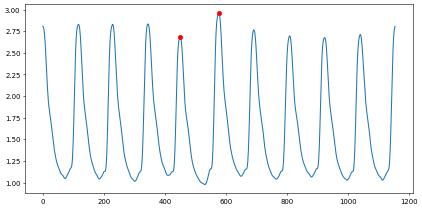

peaks' distant [176]


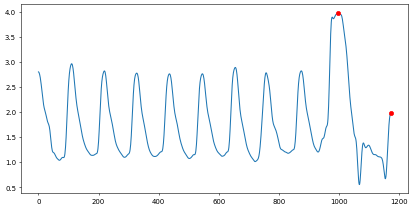

peaks' distant [129]


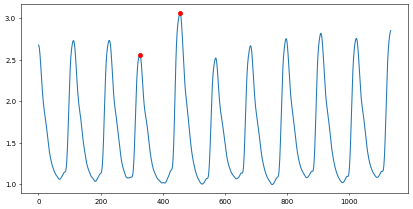

peaks' distant [130]


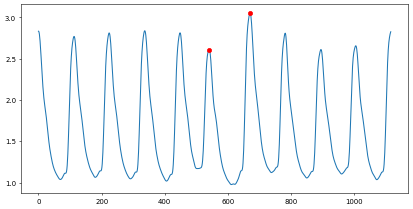

peaks' distant [126]


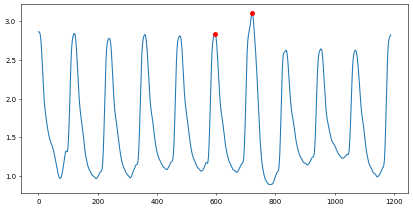

peaks' distant [147]


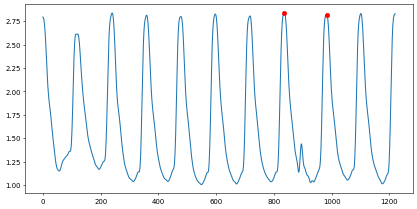

peaks' distant [150]


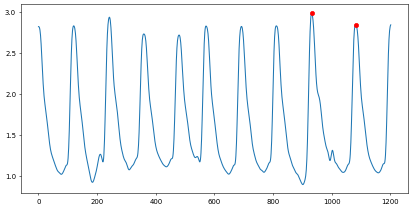

peaks' distant [140]


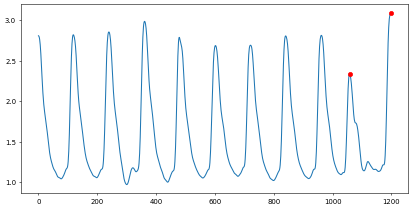

peaks' distant [148]


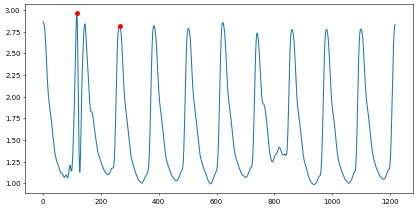

peaks' distant [173]


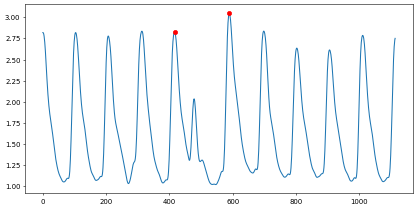

peaks' distant [143]


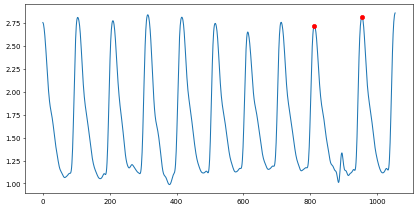

peaks' distant [171]


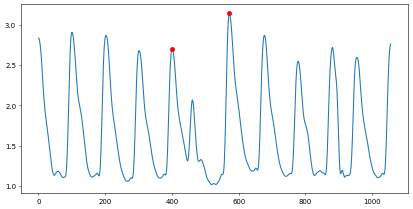

peaks' distant [131 126]


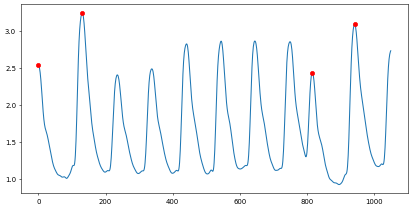

peaks' distant [188]


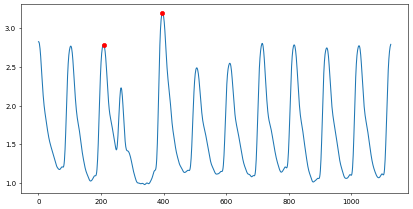

peaks' distant [138]


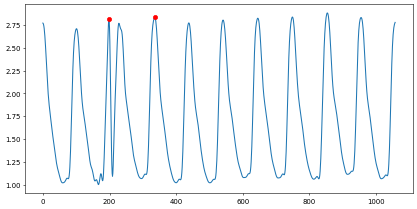

peaks' distant [134]


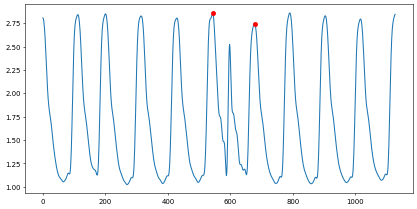

peaks' distant [145]


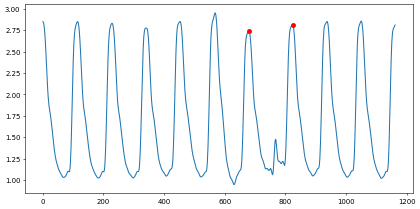

peaks' distant [138]


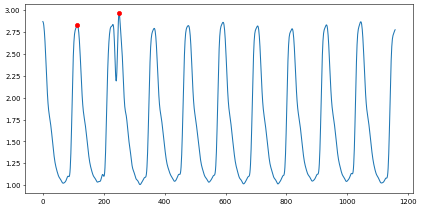

peaks' distant [134]


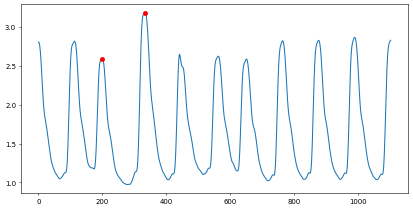

peaks' distant [128]


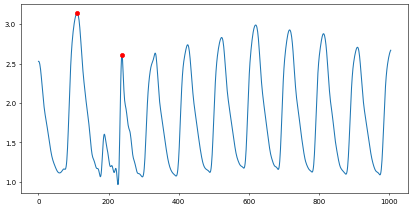

peaks' distant [188]


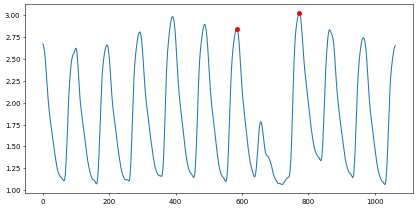

peaks' distant [195]


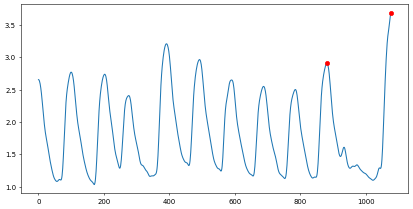

peaks' distant [182]


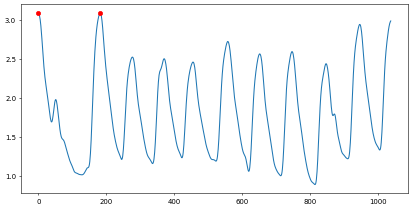

peaks' distant [194]


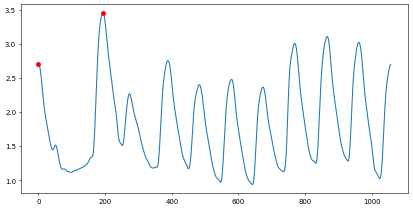

peaks' distant [183 186]


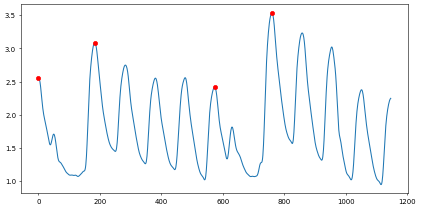

peaks' distant [186]


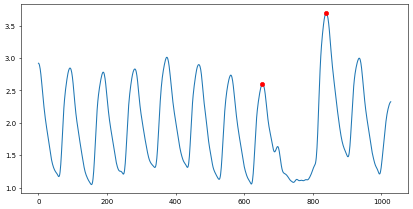

peaks' distant [168]


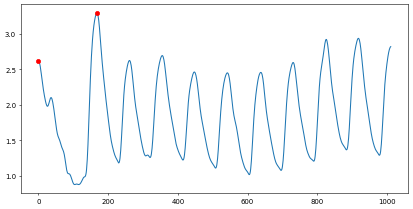

peaks' distant [136]


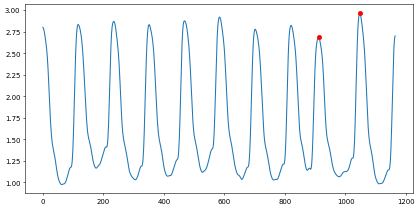

peaks' distant [155]


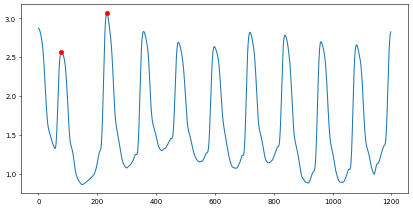

peaks' distant [127]


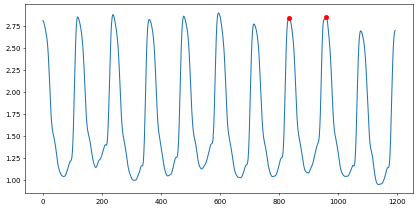

peaks' distant [152]


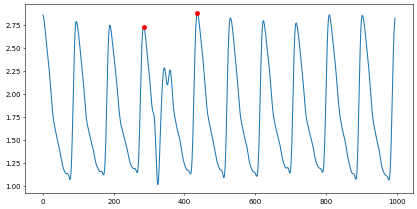

peaks' distant [126]


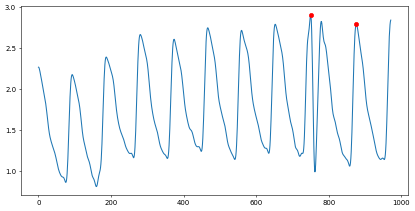

peaks' distant [142]


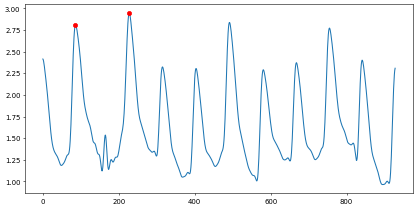

peaks' distant [128]


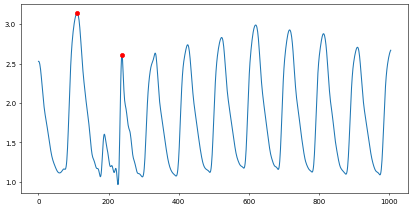

peaks' distant [188]


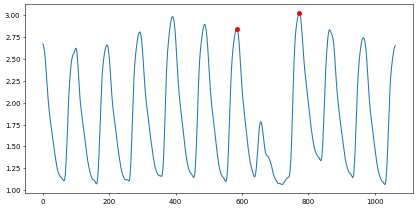

peaks' distant [195]


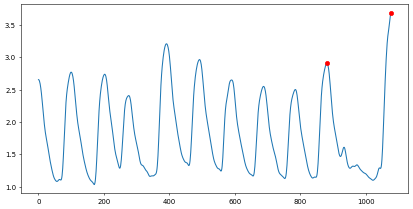

peaks' distant [182]


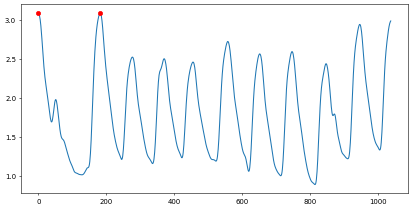

peaks' distant [194]


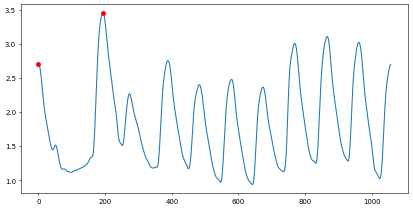

peaks' distant [183 186]


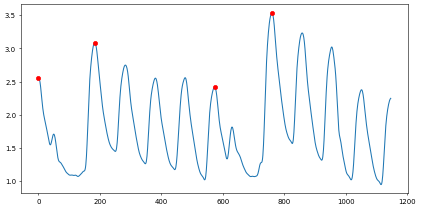

peaks' distant [186]


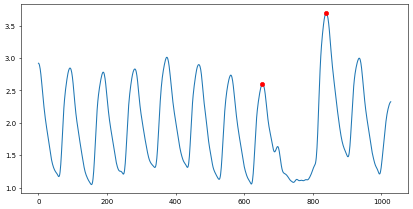

peaks' distant [168]


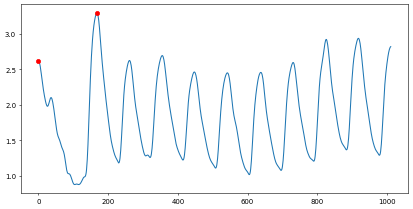

peaks' distant [158]


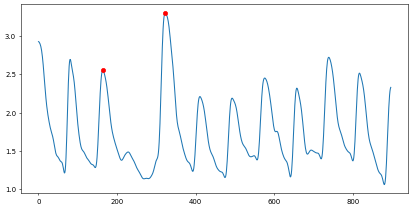

peaks' distant [138]


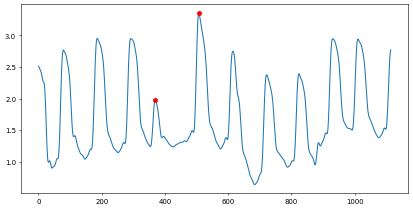

peaks' distant [137]


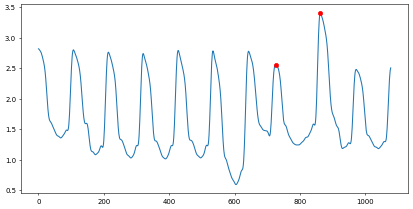

peaks' distant [139]


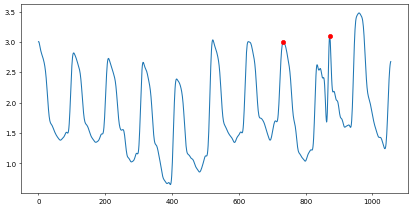

peaks' distant [126]


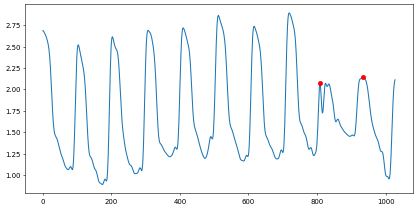

peaks' distant [157]


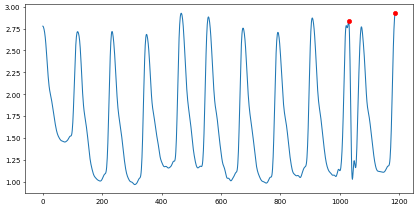

peaks' distant [144]


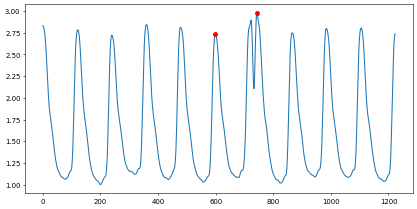

peaks' distant [138]


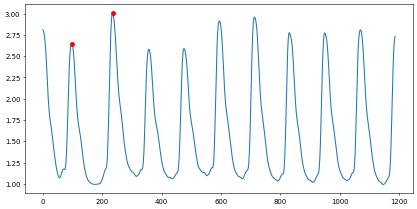

peaks' distant [163]


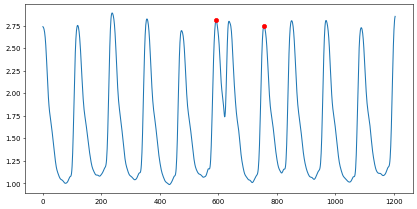

peaks' distant [141]


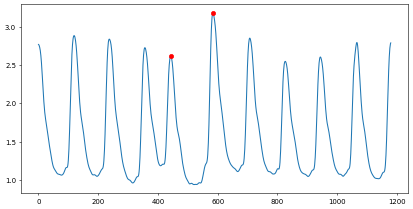

peaks' distant [136]


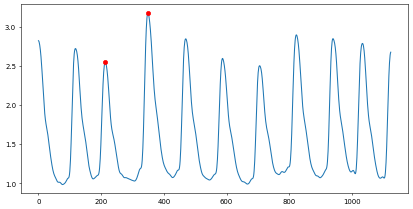

peaks' distant [160]


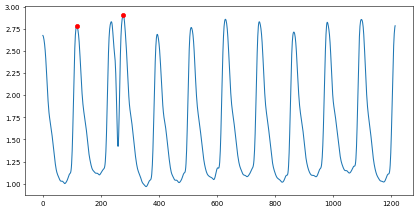

peaks' distant [139]


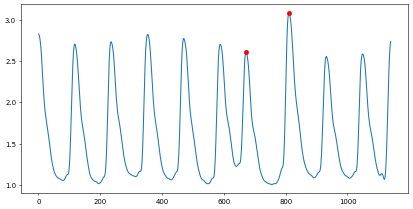

peaks' distant [39]


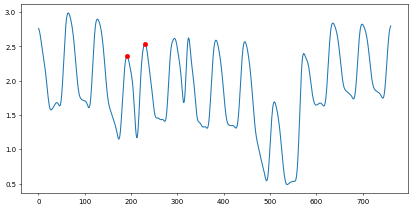

peaks' distant [140]


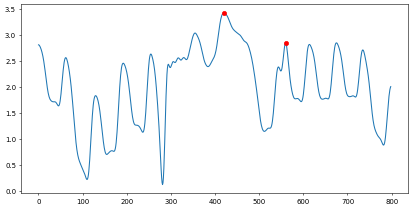

155 samples are deleted from dataset
3601 samples left
Do BP and PPG have the same number of samples? True


In [12]:
#train
Ntrain, list_array_PPG, list_array_BP = preprocess3(Ntrain, [list_array_PPG, list_array_BP] )

peaks' distant [202]


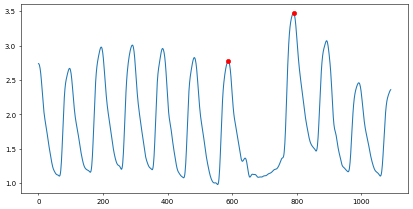

peaks' distant [200 192]


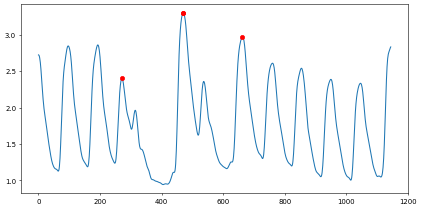

peaks' distant [190 204]


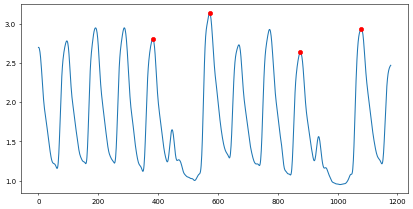

peaks' distant [182]


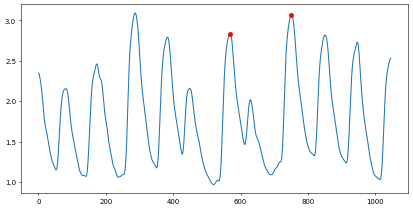

peaks' distant [140]


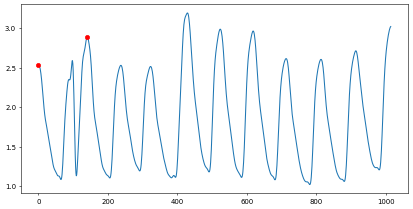

peaks' distant [273]


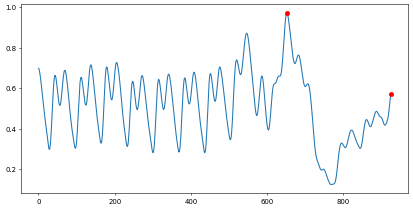

peaks' distant [159]


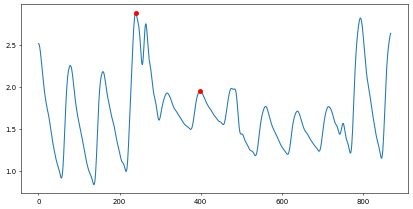

7 samples are deleted from dataset
405 samples left


In [13]:
#test
Ntest, list_array_PPG_test = preprocess3(Ntest, [list_array_PPG_test], test_data=True)

check lenght of samples to find max and min (length) samples

smaple 2714 has max length 1215
smaple 1133 has min length 552


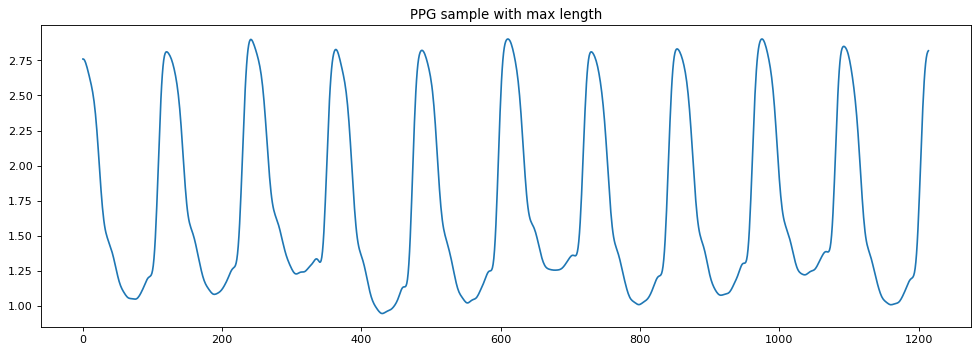

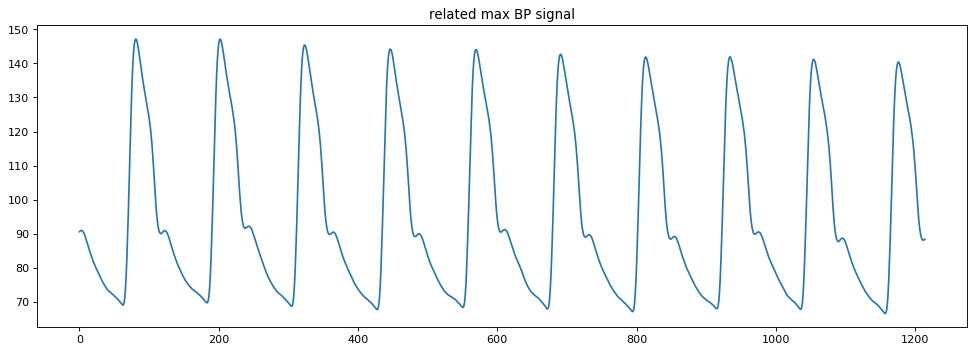

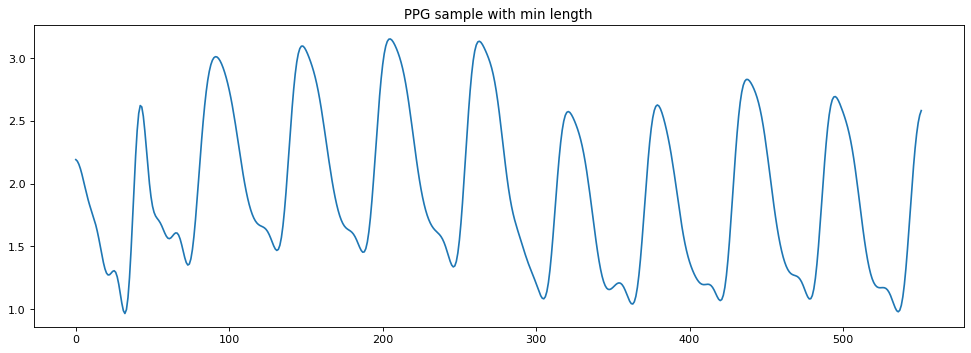

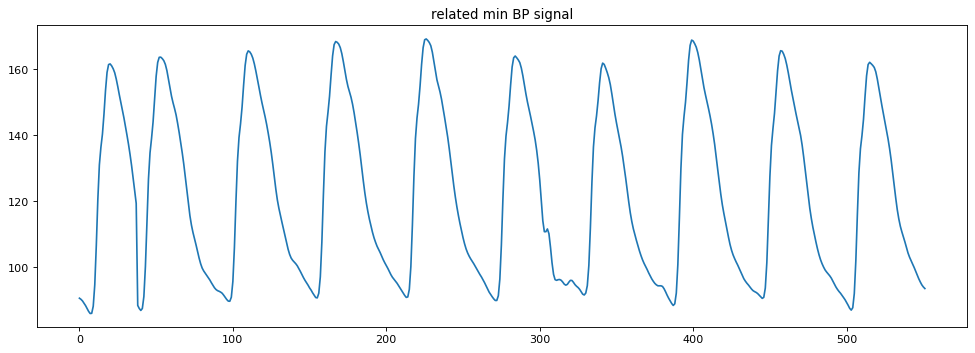

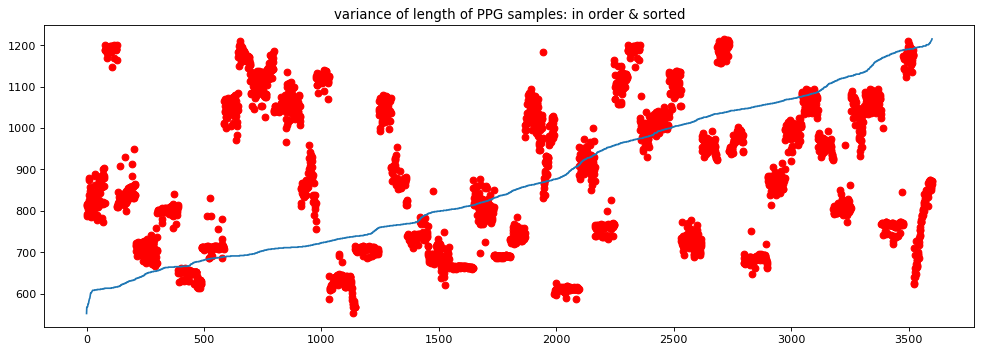

In [14]:
# check lenght
max = 0 #for max length
min = 4000 #for min length
ll = [] # list of length
#search all PPG samples for max and min length
for i in range(len(list_array_PPG)):
    ll.append(list_array_PPG[i].shape[0])
    if(max < list_array_PPG[i].shape[0]):
        max = list_array_PPG[i].shape[0]
        t2 = i
    if(min > list_array_PPG[i].shape[0]):
        min = list_array_PPG[i].shape[0]
        b2 = i

print('smaple', t2, 'has max length', max)
print('smaple', b2, 'has min length', min)

plt.figure(figsize=(15,5), dpi=80)
list_array_PPG[t2].shape[0]
plt.plot(list_array_PPG[t2])
plt.title("PPG sample with max length")
plt.show()
plt.figure(figsize=(15,5), dpi=80)
plt.title("related max BP signal")
plt.plot(list_array_BP[t2])
plt.show()
plt.figure(figsize=(15,5), dpi=80)
plt.title("PPG sample with min length")
plt.plot(list_array_PPG[b2])
plt.show()
plt.figure(figsize=(15,5), dpi=80)
plt.title("related min BP signal")
plt.plot(list_array_BP[b2])
plt.show()

plt.figure(figsize=(15,5), dpi=80)
plt.plot(ll, 'ro')
ll = np.sort(ll)
plt.plot(ll)
plt.title("variance of length of PPG samples: in order & sorted")
plt.show()

Find **systolic** and **diastolic** values for each PPG sample from BP signal; threshold will omit nonvalid systolic and diastolic peaks from averaging, as shown in figures, connected dots take place in averaging

figures show deleted peaks of related samples


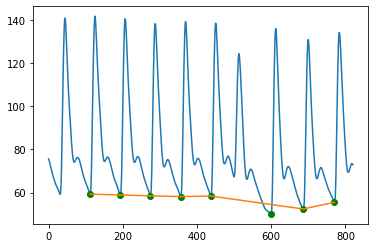

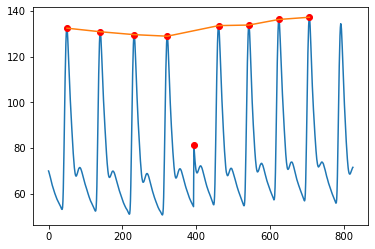

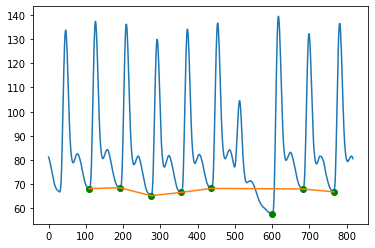

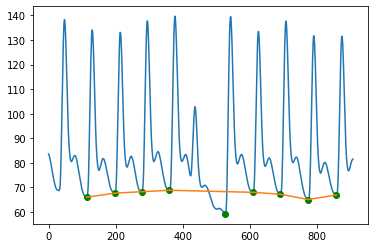

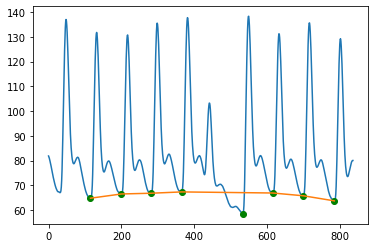

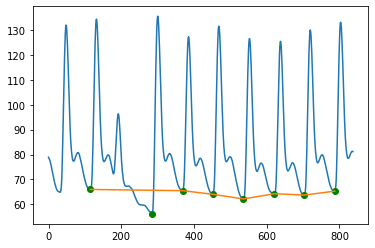

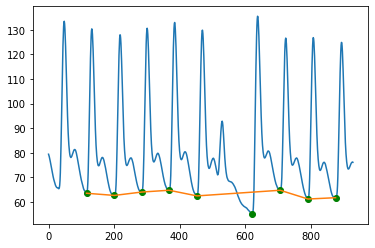

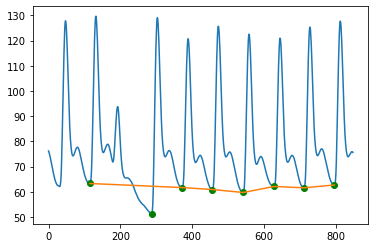

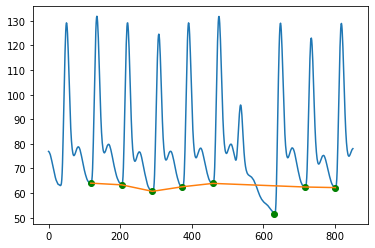

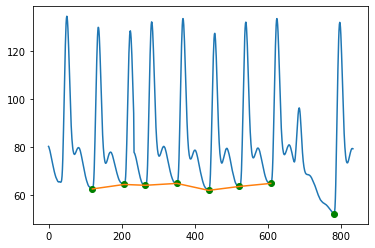

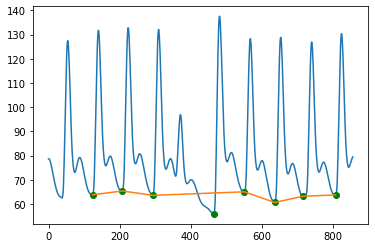

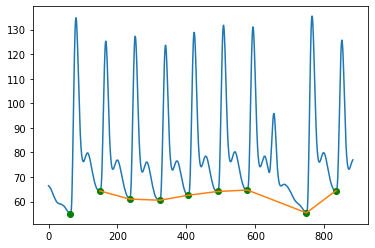

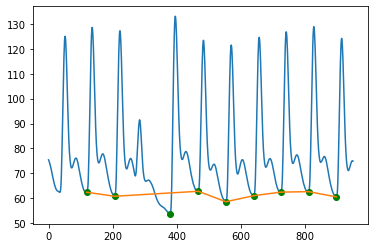

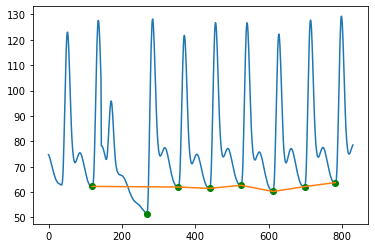

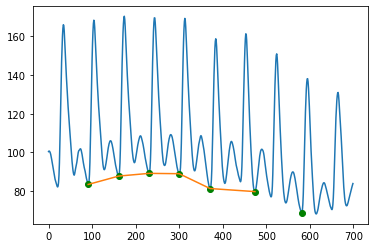

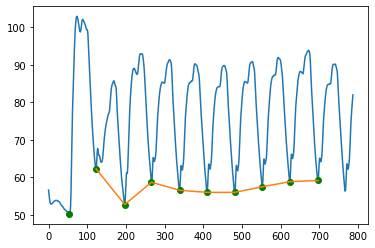

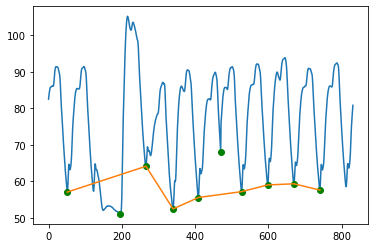

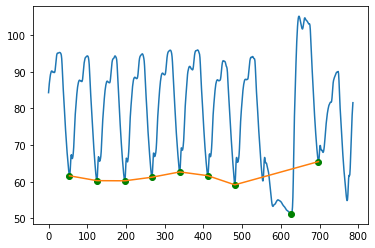

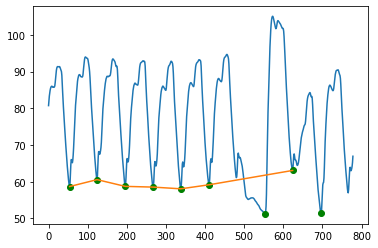

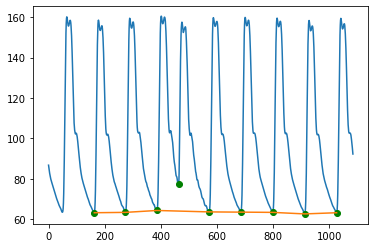

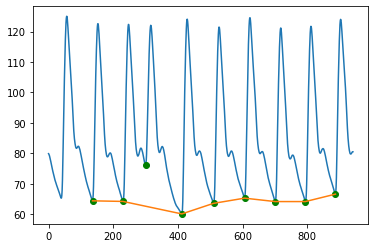

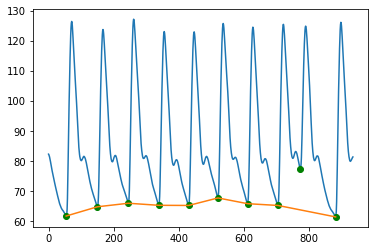

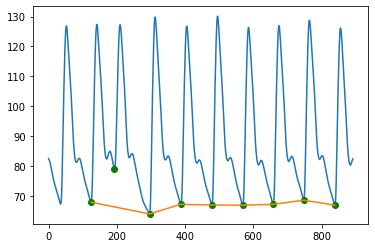

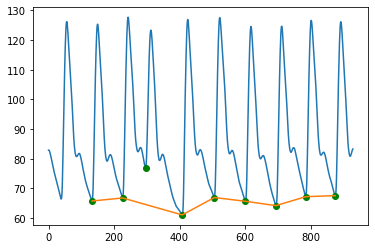

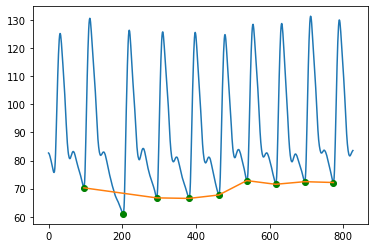

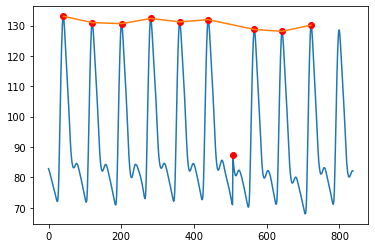

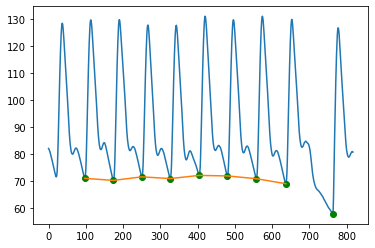

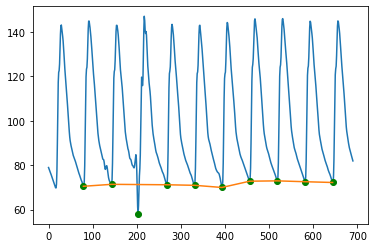

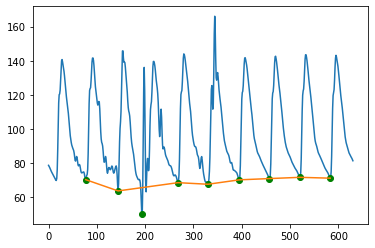

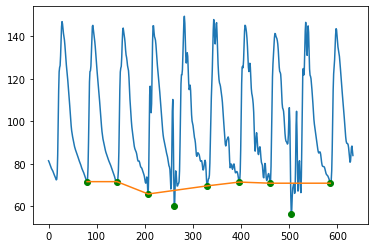

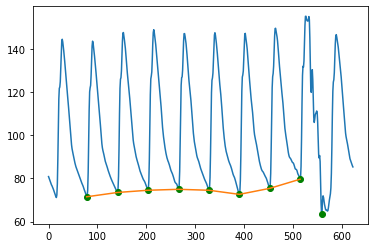

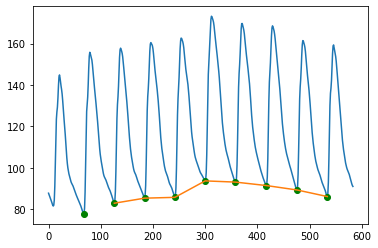

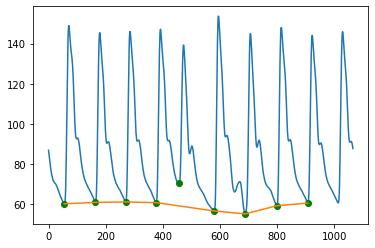

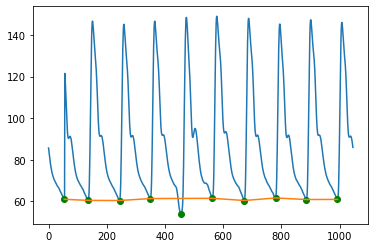

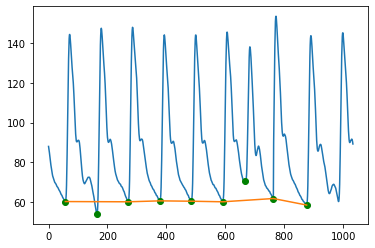

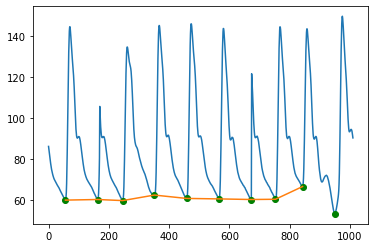

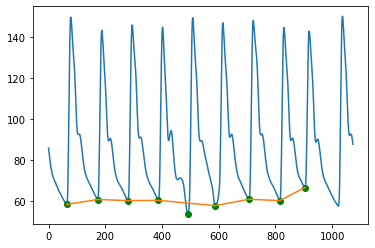

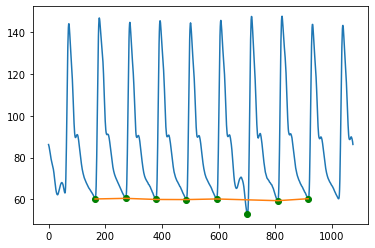

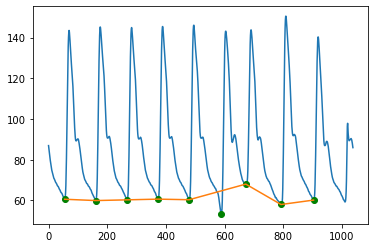

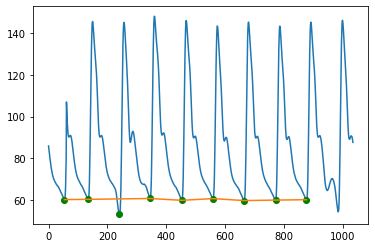

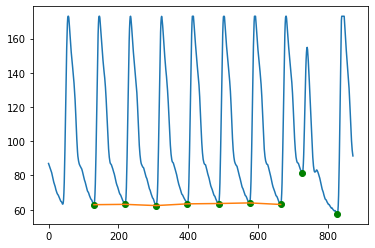

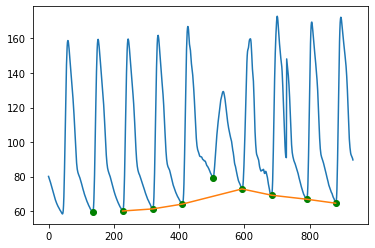

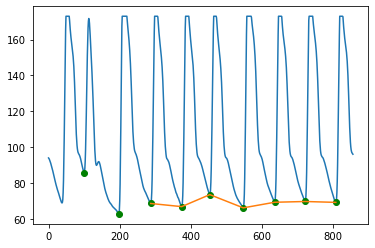

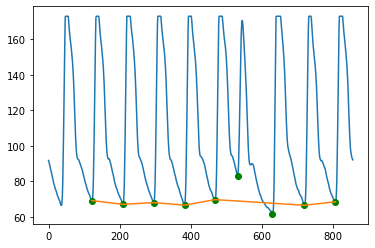

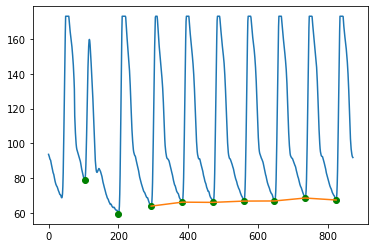

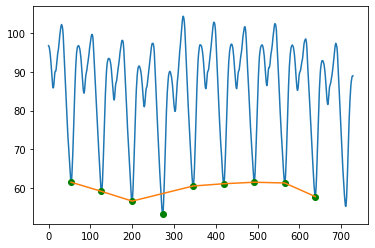

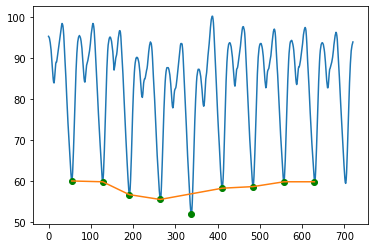

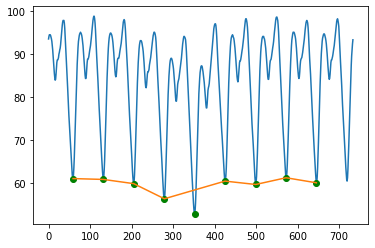

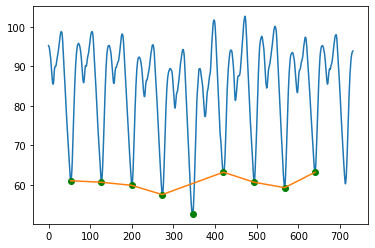

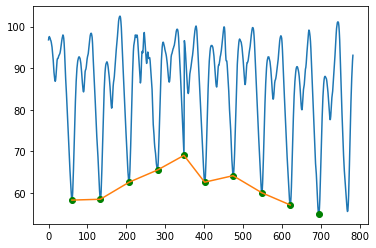

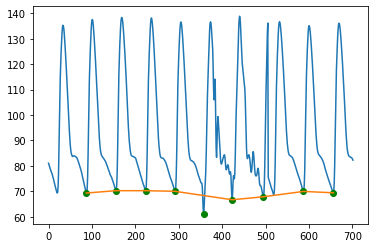

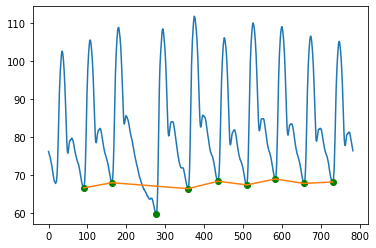

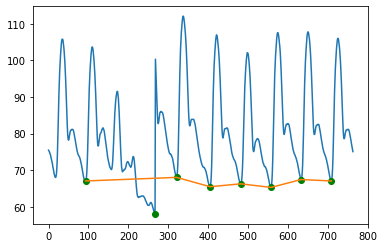

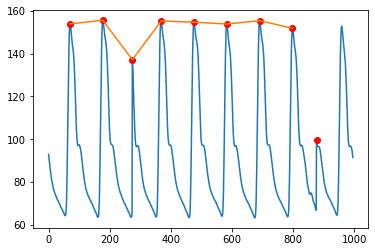

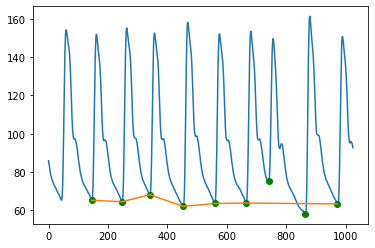

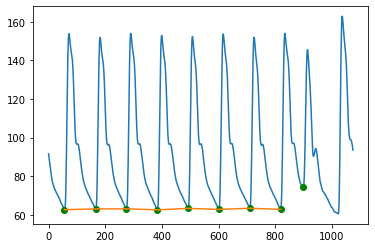

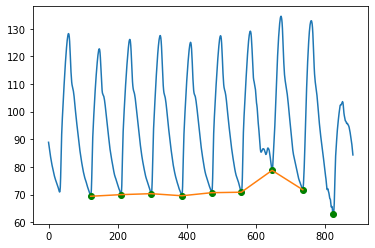

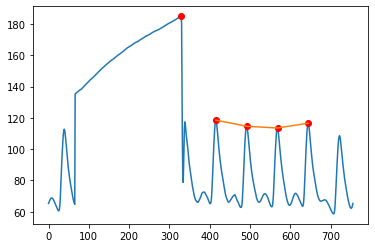

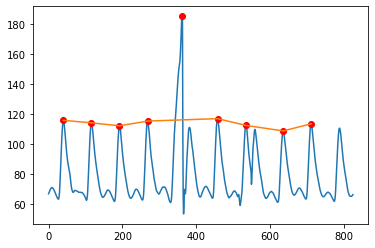

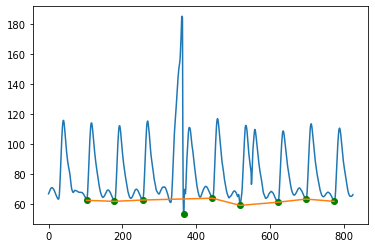

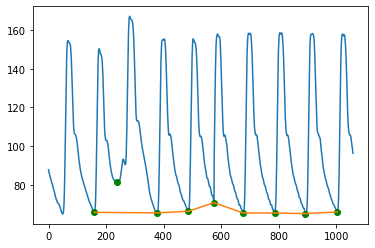

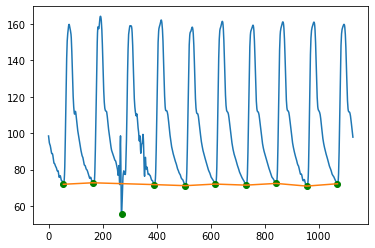

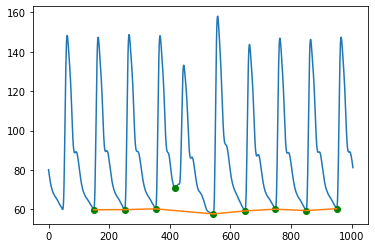

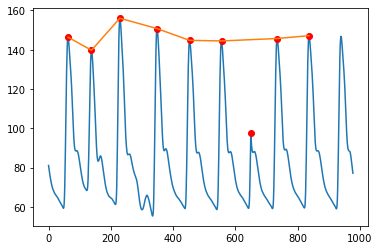

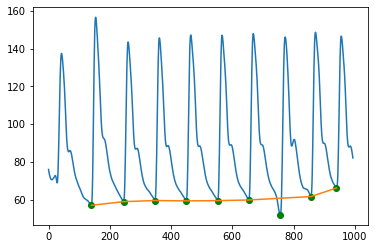

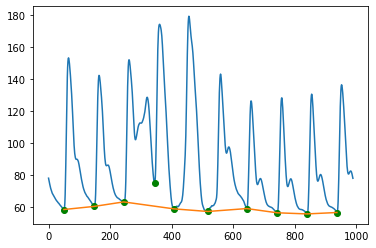

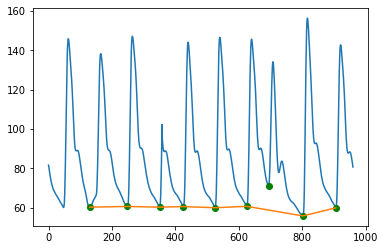

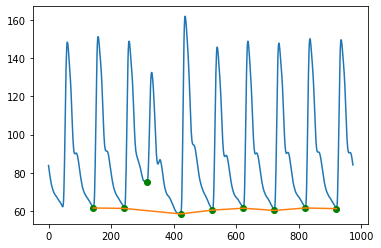

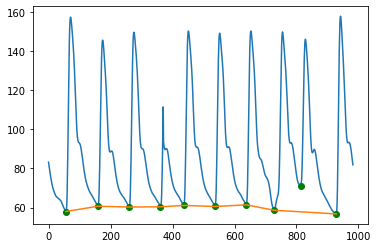

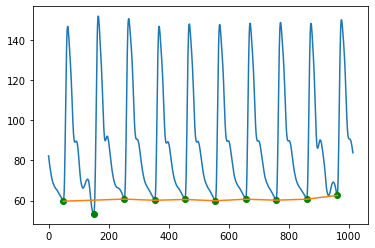

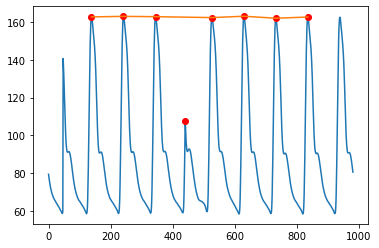

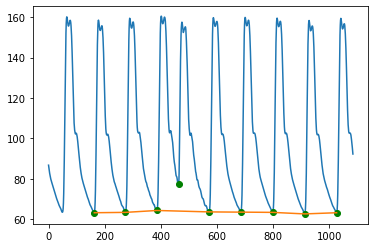

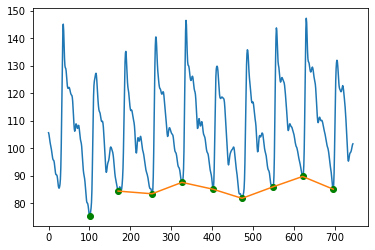

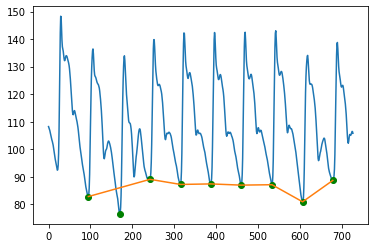

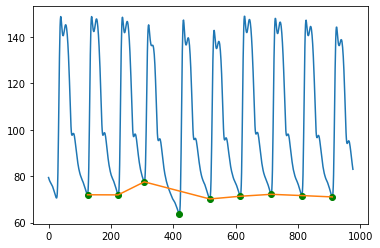

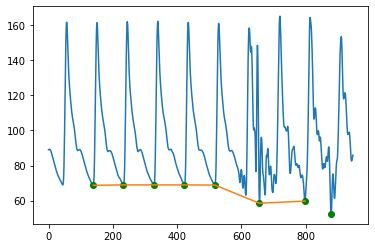

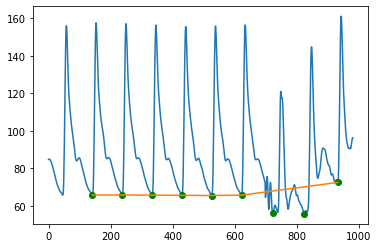

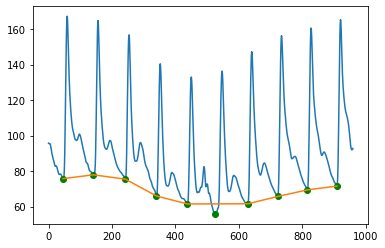

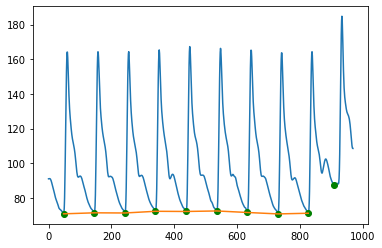

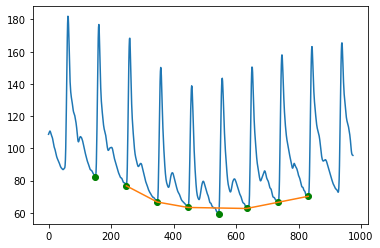

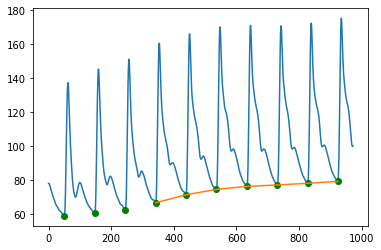

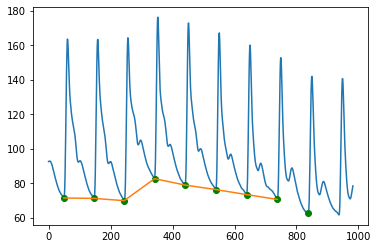

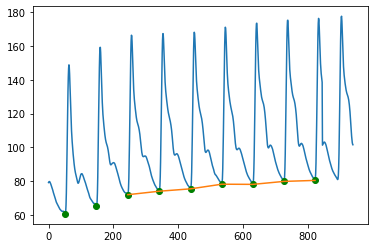

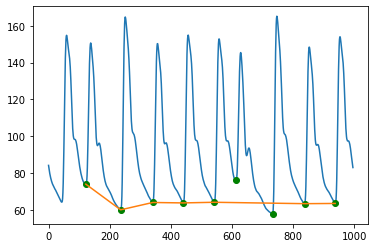

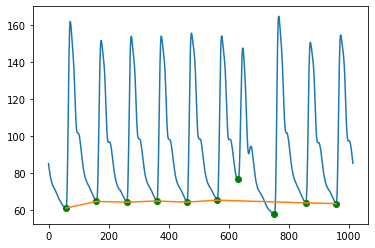

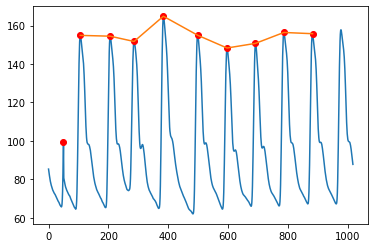

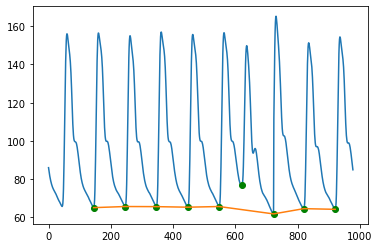

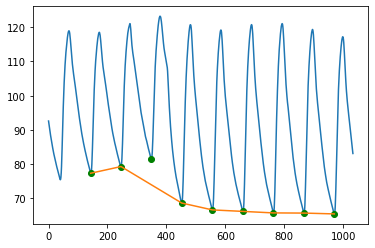

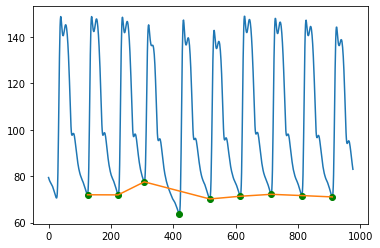

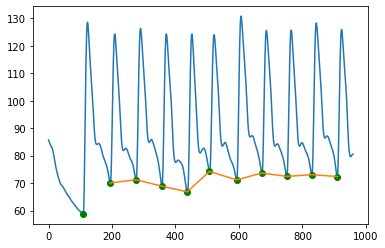

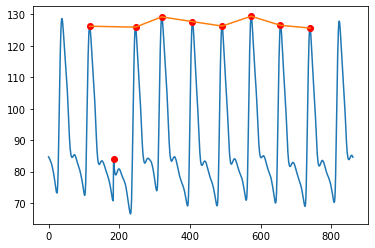

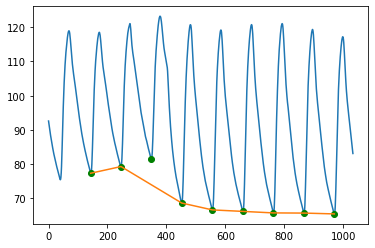

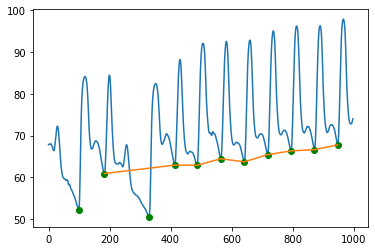

In [15]:
#find systolic and diastolic
print("figures show deleted peaks of related samples")
systolic  = np.zeros(len(list_array_BP))
diastolic = np.zeros(len(list_array_BP))
for i in range(len(list_array_BP)):
    BP = list_array_BP[i]
    ps = ampd(BP)   #systolic peak
    pd = ampd(-BP) #diastolic peak
    p_avg_s = np.mean(BP[ps])
    p_avg_d = np.mean(BP[pd])
    nonvalid_peak_s = (BP[ps] < 0.7 * p_avg_s) + (BP[ps] > 1.4 * p_avg_s)
    nonvalid_peak_d = (BP[pd] < 0.9 * p_avg_d) + (BP[pd] > 1.15 * p_avg_d)
    ps_new = np.delete(ps, nonvalid_peak_s, axis=None)
    pd_new = np.delete(pd, nonvalid_peak_d, axis=None)
    systolic[i]  = np.mean(BP[ps_new[:]])  #mean of valid systolic peaks
    diastolic[i] = np.mean(BP[pd_new[:]]) #mean of valid diastolic peaks
    if np.any(nonvalid_peak_s) and plot_flag:
        plt.plot(BP)
        plt.plot(ps, BP[ps], 'or')
        plt.plot(ps_new, BP[ps_new])
        plt.show()
    if np.any(nonvalid_peak_d) and plot_flag:# && i%2==0 plot some of them
        plt.plot(BP)
        plt.plot(pd, BP[pd], 'og')
        plt.plot(pd_new, BP[pd_new])
        plt.show()

In [16]:
print('lenght of systolic and diastolic targets', len(systolic), len(diastolic))  
#check if miss any peak average
print('Is there any nonvalid systolic?', np.any(systolic == 0))
print('Is there any nonvalid diastolic?', np.any(diastolic == 0))

lenght of systolic and diastolic targets 3601 3601
Is there any nonvalid systolic? False
Is there any nonvalid diastolic? False


In [17]:
# add zero to have equall-size train samples
Nsample = len(list_array_PPG)
X = np.zeros((Nsample, max))

for i in range(Nsample):
    signal = list_array_PPG[i]
    j = signal.shape[0]
    X[i,:j] = signal

In [18]:
#shuffle X, ys and yd
X, ys, yd = shuffle(X, systolic, diastolic, random_state=42)
print('shape of PPG samples', X.shape)
print('shape of systolic target', ys.shape) 
print('shape of diastolic target', yd.shape)

shape of PPG samples (3601, 1215)
shape of systolic target (3601,)
shape of diastolic target (3601,)


In [19]:
# add zero to have equall-size test samples
Nsample = len(list_array_PPG_test)
X_test = np.zeros((Nsample, max))

for i in range(Nsample):
    signal = list_array_PPG_test[i]
    j = signal.shape[0]
    X_test[i,:j] = signal

The last part of preprocessing using PCA for dimention reduction but to prevent test part of data in cross validation, it comes right before using each model and after splitting train and test samples at each iteration.

In [20]:
def preprocess4(X_train, X_test, pca_comp):
    st = StandardScaler()
    pca = PCA(n_components=pca_comp)
    #normalize
    X_train = st.fit_transform(X_train)# no usage of test data
    X_test = st.transform(X_test)# X_test is calculated due to X_train
    #dimention reduction
    X_train = pca.fit_transform(X_train)# no usage of test data
    X_test = pca.transform(X_test)# X_test is calculated due to X_train
    return X_train, X_test

### C) Base-line model:

mean of BP values

In [21]:
# base_line model
BL_ys = np.mean(ys)
sBL_rss = np.sum((ys - BL_ys)**2)
print('total sum of squers for base-line model systolic', sBL_rss)
BL_yd = np.mean(yd)
dBL_rss = np.sum((yd - BL_yd)**2)
print('total sum of squers for base-line model diastolic', dBL_rss)
#RMS
acc_base_s = 1 - np.sqrt(np.mean(((ys - BL_ys)/ys)**2))
acc_base_d = 1 - np.sqrt(np.mean(((yd - BL_yd)/yd)**2))
print('base-line model accuracy: systolic', acc_base_s*100, '% | diastolic', acc_base_d*100, '%')

total sum of squers for base-line model systolic 1745325.2577640866
total sum of squers for base-line model diastolic 190758.9322637975
base-line model accuracy: systolic 81.4674758931504 % | diastolic 89.42729293237501 %


### C) Main model

using cross validation to find best model with least test error.

each model has tow function: 

1. main function (with lower case) to train based on train data and find total sum of squers for train and test.

2. and the other function (with upper case) to preform inner section of nested cross validation. 

Simple linear Regression which has no hyper parameter

In [22]:
def LR_simple(x_train, y_train, x_test, y_test):
    mode = LinearRegression()
    mode.fit(x_train, y_train)
    yp = mode.predict(x_test)
    rss_test = ((yp - y_test) ** 2).sum()
    #print((yp - y_test).T)
    yp = mode.predict(x_train)
    rss_train = ((yp - y_train) ** 2).sum()
    #print(rss_train/900, rss_test/100)
    return rss_train, rss_test

Lasso linear regression

In [23]:
def lasso(X_train, y_train, X_test, y_test, L):
    st = StandardScaler()
    X_train = st.fit_transform(X_train)
    X_test = st.transform(X_test)
    mode = Lasso(alpha=L, normalize=False, max_iter = 10000)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_test)
    rss_test = ((yp - y_test) ** 2).sum()
    yp = mode.predict(X_train)
    rss_train = ((yp - y_train) ** 2).sum()
    return rss_train, rss_test

In [24]:
def LR_Lasso(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = lasso, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = lasso(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Ridge linear regression

In [25]:
def ridge(X_train, y_train, X_test, y_test, L):
    st = StandardScaler()
    X_train = st.fit_transform(X_train)
    X_test = st.transform(X_test)
    mode = Ridge(alpha=L, normalize=False)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_test)
    rss_test = ((yp - y_test) ** 2).sum()
    yp = mode.predict(X_train)
    rss_train = ((yp - y_train) ** 2).sum()
    return rss_train, rss_test

In [26]:
def LR_Ridge(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = ridge, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)# CV)
    rss_train, rss_test = ridge(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Support Vector Machine regression

In [27]:
def svr(X_train, y_train, X_test, y_test, c, final_model=False):
    mode = SVR(epsilon=0, C=c, max_iter=100000, tol = 1e-5, kernel = 'rbf', gamma=1e-1)
    mode.fit(X_train, y_train)
    yp = mode.predict(X_train)
    acc = 1 - np.sqrt(np.mean(((y_train - yp)/y_train)**2))
    rss_train = ((yp - y_train) ** 2).sum()
    yp = mode.predict(X_test)
    if final_model:
        return rss_train, yp, acc
    #--------------------------------------
    rss_test = ((yp - y_test) ** 2).sum()
    return rss_train, rss_test

In [28]:
def LR_SVR(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = svr, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = svr(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Random Forest regression

In [29]:
def forest(X_train, y_train, X_test, y_test, hp, final_model=False):
    #mode = RForest(max_features='auto', n_estimators=n, max_depth=d, n_jobs = -1, random_state=42)
    mode = RForest(n_estimators=int(hp), random_state=0)
    #----max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    mode.fit(X_train, y_train)
    yp = mode.predict(X_train)
    acc = 1 - np.sqrt(np.mean(((y_train - yp)/y_train)**2))
    rss_train = ((yp - y_train) ** 2).sum()
    yp = mode.predict(X_test)
    if final_model:
        return rss_train, yp, acc
    #--------------------------------------
    rss_test = ((yp - y_test) ** 2).sum()
    return rss_train, rss_test

In [30]:
def RandomForest(X_train, y_train, X_test, y_test, alphaL):
    CV = []
    for l in alphaL:#n_estimators
        #inner CV to choose best hyperP for each iteration of outter iterations of nested CV
        cv = Kfold_CV(X_train, y_train, model = forest, HyperP=l)
        CV.append(cv)
    L_index = np.argmin(np.array(CV)) 
    selected_L = alphaL[L_index]
    print('Selected Hyper Parameter', selected_L)#, CV)
    rss_train, rss_test = forest(X_train, y_train, X_test, y_test, selected_L)
    return rss_train, rss_test

Cross validation Function

In [31]:
def Kfold_CV(X, y, model, HyperP, K=5, pca_comp=50):
    #HyperP is a single value or a list of hyper parameter that will check with CV
    kf = KFold(n_splits=K)
    kf.get_n_splits(X)
    CV = 0
    for train_index, test_index in kf.split(X):
        #split test and train
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #------------------------------------------------------------------------
        #part 3 of preprocessing: PCA
        X_train, X_test = preprocess4(X_train, X_test, pca_comp)
        #------------------------------------------------------------------------
        if HyperP == None : #models with no hyperparameter 
            rss_train, rss_test = model(X_train, y_train, X_test, y_test)
            #print(CV, rss_train, rss_test)
        else: #models with hyperparameter 
            rss_train, rss_test = model(X_train, y_train, X_test, y_test, HyperP)
        #------------------------------------------------------------------------
        #print(rss_train, rss_test)
        CV += rss_test
    CV = CV / X.shape[0]
    #print(CV)
    #print(len(X), X.shape[0])
    return CV

using nested Cross Validation for model selection.

model with less Cross value will be chosen as best model


# Systolic

In [32]:
#systolic
#nested Cross Validation for model selection
CV_simple = Kfold_CV(X, ys, LR_simple, HyperP=None)
print('LR simple CV', CV_simple, '\n')
HP = [0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]#HyperP
cHP = [0.001, 0.01, 0.1, 1, 10, 100]#hyperP only for SVM
HPrf = [100, 200, 300]#hyperP only for random farest as n_estimators
# becuase of hardware resources can't expand hyper parameter search value or use grid search on multi parameters
CV_min = CV_simple
best_model = "simple"
CV_Ridge = Kfold_CV(X, ys, LR_Ridge, HP)
print('Ridge CV', CV_Ridge, '\n')
if CV_min > CV_Ridge:
    CV_min = CV_Ridge
    best_model = "ridge"
CV_Lasso = Kfold_CV(X, ys, LR_Lasso, HP)
print('Lasso CV', CV_Lasso, '\n')
if CV_min > CV_Lasso:
    CV_min = CV_Lasso
    best_model = "lasso"
CV_svr = Kfold_CV(X, ys, LR_SVR, HyperP=cHP)
print('SVM CV', CV_svr, '\n')
if CV_min > CV_svr:
    CV_min = CV_svr
    best_model = "svr"
CV_RF = Kfold_CV(X, ys, RandomForest, HPrf)
print('RandomForest CV', CV_RF, '\n')
if CV_min > CV_RF:
    CV_min = CV_RF
    best_model = "rf"
print('best CV is', CV_min, 'for model', best_model)

LR simple CV 244.30549178263152 

Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Ridge CV 244.18408092030208 

Selected Hyper Parameter 0.1
Selected Hyper Parameter 0.1
Selected Hyper Parameter 0.1
Selected Hyper Parameter 0.1
Selected Hyper Parameter 0.1
Lasso CV 244.74193842467272 

Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
SVM CV 240.58832863280549 

Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
RandomForest CV 117.75623527783924 

best CV is 117.75623527783924 for model rf


After selecting best model, using simple cross validation to choose hyper parameter.

In [33]:
#systolic
#selecting hyper parameter
if best_model == 'rf':
    HP = [200, 300, 400] #values around selected hyperP from previuos section
else:
    HP = [1, 10, 100, 1000] #values around selected hyperP from previuos section
CV_min = 1e10
best_HP = 0
for h in HP:
    if best_model == 'lasso':
        CV_ = Kfold_CV(X, ys, lasso, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'ridge':
        CV_ = Kfold_CV(X, ys, ridge, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'svr':
        CV_ = Kfold_CV(X, ys, svr, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'rf':
        CV_ = Kfold_CV(X, ys, forest, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
print('best model', best_model, 'with hyper parameter', best_HP, '& CV:', CV_min)

hyper parameter 200 with CV 117.36772363723078
hyper parameter 300 with CV 117.93630279964664
hyper parameter 400 with CV 118.21226552431393
best model rf with hyper parameter 200 & CV: 117.36772363723078


best number of component for PCA is 80 with CV 114.71083647006571


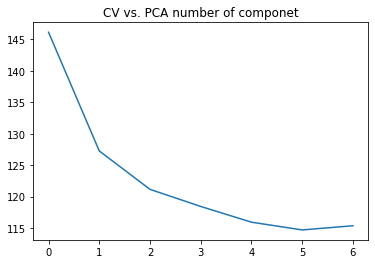

In [34]:
#systolic
#choose pca number of component as another hyper parameter
CV_min = 800
pcaa = []
for c in range(5,100, 15): #search for 2 to 105 PCA component for best model
        CV_ = Kfold_CV(X, ys, forest, best_HP, pca_comp=c)
        if CV_min > CV_:
            CV_min = CV_
            best_pca = c #select pca_comp with less CV
        pcaa.append(CV_)# save CV to plot
        #print(c, CV_)
print('best number of component for PCA is', best_pca, 'with CV', CV_min)
plt.plot(pcaa)
plt.title('CV vs. PCA number of componet')
plt.show()

Finally after selecting best model and all hyper parameters, train model with all train data and predict on PPG test samples.

In [35]:
#systolic
#part 3 of preprocessing: PCA
X_, X_t = preprocess4(X, X_test, best_pca)
#------------------------------------------------------------------------
#train on whole data and predicting
if best_model == "simple":
    rss_s, _ = LR_simple(X_, ys, X_t, ys)
elif best_model == "ridge":
    rss_s, _ = ridge(X_, ys, X_t, ys, best_HP)
elif best_model == "lasso":
    rss_s, _ = lasso(X_, ys, X_t, ys, best_HP)
elif best_model == "svr":
    rss_s, s2_predicted_s, acc_s = svr(X_, ys, X_t, ys, best_HP, final_model=True)
elif best_model == "rf":
    rss_s, s2_predicted_s, acc_s = forest(X_, ys, X_t, ys, best_HP, final_model=True)

print("model:", best_model, 'with hyper parameter', best_HP)
print('total sum of squers:', rss_s)
print('accuracy of model on train set:', acc_s * 100, '%')

model: rf with hyper parameter 200
total sum of squers: 53217.07324997791
accuracy of model on train set: 96.86162132214211 %


In [36]:
#systolic
print('improvment of total sum of squers:', (1 - rss_s/sBL_rss)*100, '%')
print('improvment of accuracy:', (acc_s/acc_base_s - 1)*100, '%')

improvment of total sum of squers: 96.95087932674775 %
improvment of accuracy: 18.89606282779901 %


In [37]:
print(s2_predicted_s)
np.save('s2_predicted_systolic.npy', s2_predicted_s)

[145.60393888 147.01135808 146.81899698 145.91839098 147.40841133
 145.67797249 144.55205087 147.98533616 147.12243512 151.48464695
 146.98830331 149.142961   144.81043262 146.08391879 152.06289242
 152.31249225 149.61733149 146.92186225 146.65068226 150.74936664
 146.57041089 146.93505734 151.06637866 149.53175866 146.07310443
 146.92000586 145.80282878 150.55709171 149.7904123  148.43551082
 145.8745813  146.31032222 140.40118305 150.07795236 146.96853184
 144.96677647 148.07508769 142.87515339 146.35020964 151.42378689
 146.82964684 147.27228926 146.23951544 145.83683986 147.11300762
 146.54240342 146.61143402 146.39847136 146.82849342 144.59937436
 149.41134716 144.24233823 146.56794605 144.29080081 149.03749593
 147.83976402 135.03886242 141.50969718 146.98002196 151.34320263
 148.65497975 141.41868545 143.82281941 145.87294441 141.70231542
 150.58822143 154.29667887 154.44831145 154.05111411 152.74339317
 150.23917101 150.31793514 150.39116459 152.75287287 153.44044125
 152.80881

# Diastolic

In [38]:
#diastolic
#nested Cross Validation for model selection
CV_simple = Kfold_CV(X, yd, LR_simple, HyperP=None)
print('LR simple CV', CV_simple, '\n')
HP = [0.001, 0.01, 0.1, 1, 10, 100, 1e3, 1e4]#HyperP
cHP = [1, 10, 100]#hyperP only for SVM
HPrf = [100, 200, 300]#hyperP only for random farest as n_estimators
# becuase of hardware resources can't expand hyper parameter search value or use grid search on multi parameters
CV_min = CV_simple
best_model = "simple"
CV_Ridge = Kfold_CV(X, yd, LR_Ridge, HP)
print('Ridge CV', CV_Ridge, '\n')
if CV_min > CV_Ridge:
    CV_min = CV_Ridge
    best_model = "ridge"
CV_Lasso = Kfold_CV(X, yd, LR_Lasso, HP)
print('Lasso CV', CV_Lasso, '\n')
if CV_min > CV_Lasso:
    CV_min = CV_Lasso
    best_model = "lasso"
CV_svr = Kfold_CV(X, yd, LR_SVR, HyperP=cHP)
print('SVM CV', CV_svr, '\n')
if CV_min > CV_svr:
    CV_min = CV_svr
    best_model = "svr"
CV_RF = Kfold_CV(X, yd, RandomForest, HPrf)
print('RandomForest CV', CV_RF, '\n')
if CV_min > CV_RF:
    CV_min = CV_RF
    best_model = "rf"
print('best CV is', CV_min, 'for model', best_model)

LR simple CV 35.8050875600711 

Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Ridge CV 35.777989241462386 

Selected Hyper Parameter 0.01
Selected Hyper Parameter 0.01
Selected Hyper Parameter 0.01
Selected Hyper Parameter 0.01
Selected Hyper Parameter 0.01
Lasso CV 35.758861609141476 

Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
Selected Hyper Parameter 100
SVM CV 36.59002888549374 

Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
Selected Hyper Parameter 300
RandomForest CV 18.669917194007642 

best CV is 18.669917194007642 for model rf


After selecting best model, using simple cross validation to choose hyper parameter.

In [39]:
#diastolic
#selecting hyper parameter
if best_model == 'rf':
    HP = [200, 300, 400]
else:
    HP = [1, 10, 100, 1000] #value around selected hyperP from previuos section
CV_min = 1e10
best_HP = 0
for h in HP:
    if best_model == 'lasso':
        CV_ = Kfold_CV(X, yd, lasso, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'ridge':
        CV_ = Kfold_CV(X, yd, ridge, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'svr':
        CV_ = Kfold_CV(X, yd, svr, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
    if best_model == 'rf':
        CV_ = Kfold_CV(X, yd, forest, h)
        if CV_min > CV_:
            CV_min = CV_
            best_HP = h
        print('hyper parameter', h, 'with CV', CV_)
print('best model', best_model, 'with hyper parameter', best_HP, '& CV:', CV_min)

hyper parameter 200 with CV 18.724983726911944
hyper parameter 300 with CV 18.71526773010993
hyper parameter 400 with CV 18.648158351130828
best model rf with hyper parameter 400 & CV: 18.648158351130828


best number of component for PCA is 95 with CV 17.56424096619744


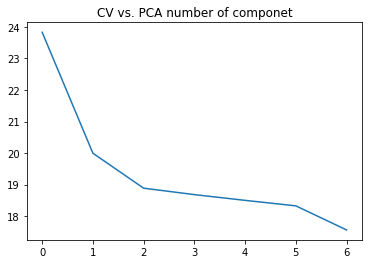

In [40]:
#diastolic
#choose pca number of component as another hyper parameter
CV_min = 800
pcaa = []
for c in range(5,100, 15): #search for 2 to 105 PCA component for best model
        CV_ = Kfold_CV(X, yd, forest, best_HP, pca_comp=c)
        if CV_min > CV_:
            CV_min = CV_
            best_pca = c #select pca_comp with less CV
        pcaa.append(CV_)# save CV to plot
        #print(c, CV_)
print('best number of component for PCA is', best_pca, 'with CV', CV_min)
plt.plot(pcaa)
plt.title('CV vs. PCA number of componet')
plt.show()

Finally after selecting best model and all hyper parameters, train model with all train data and predict on PPG test samples.

In [41]:
#diastolic
#part 3 of preprocessing: PCA
X_, X_t = preprocess4(X, X_test, best_pca)
#------------------------------------------------------------------------
#train on whole data and predicting
if best_model == "simple":
    rss_d, _ = LR_simple(X_, yd, X_t, ys)
elif best_model == "ridge":
    rss_d, _ = ridge(X_, yd, X_t, yd, best_HP)
elif best_model == "lasso":
    rss_d, _ = lasso(X_, yd, X_t, yd, best_HP)
elif best_model == "svr":
    rss_d, s2_predicted_d, acc_d = svr(X_, yd, X_t, yd, best_HP, final_model=True)
elif best_model == "rf":
    rss_d, s2_predicted_d, acc_d = forest(X_, yd, X_t, yd, best_HP, final_model=True)

print("model:", best_model, 'with hyper parameter', best_HP)
print('total sum of squers:', rss_d)
print('accuracy of model on train set:', acc_d * 100, '%')

model: rf with hyper parameter 400
total sum of squers: 8132.368444420102
accuracy of model on train set: 97.75991785266693 %


In [42]:
#diastolic
print('improvment of total sum of squers:', (1 - rss_d/dBL_rss)*100, '%')
print('improvment of accuracy:', (acc_d/acc_base_d - 1)*100, '%')

improvment of total sum of squers: 95.73683478518637 %
improvment of accuracy: 9.317764909414251 %


In [43]:
print(s2_predicted_d)
np.save('s2_predicted_d.npy', s2_predicted_d)

[70.56875476 72.28093093 69.16322176 69.98950775 73.77135566 71.33701248
 72.78918897 69.37698509 70.28134805 63.69816589 70.45935006 64.12501725
 67.99639343 68.20385401 65.72737696 68.46932458 68.36163033 66.73194305
 69.27479303 69.39320433 72.13141216 69.91040953 67.65498949 70.7262399
 68.78651191 68.15056364 71.77883196 68.03960521 67.17762338 69.06073424
 72.77294469 71.95869154 67.48911775 69.09269831 70.25087229 72.3724994
 70.91557579 67.40667932 70.75932463 71.1399713  68.95965752 70.57242095
 72.85121809 71.10150598 68.32024962 69.30488051 72.31627802 71.99161361
 63.911008   71.04189277 69.67372745 68.1388468  71.23333959 70.61061553
 70.14473185 72.24341583 70.40328021 68.67733929 68.7815073  69.33234683
 70.07221083 68.75478169 71.8018516  70.34496474 65.94422805 65.25329715
 63.98234224 64.9199619  64.6540765  64.07488383 64.77399966 64.68592203
 65.06590977 64.58938724 64.78960486 64.48699184 66.09483184 64.07563877
 65.21435797 63.55600503 64.23853808 64.48636839 63.0